<a href="https://colab.research.google.com/github/marcelodeoribeiro/MVP_analise_dados_boas_praticas/blob/main/MVP_Sprint_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - SPRINT: ANÁLISE DE DADOS E BOAS PRÁTICAS

##1. Definição do Problema

**INFORMAÇÕES SOBRE OS DADOS:** Os dados em questão são provenientes de campanhas de marketing direto realizadas por uma instituição bancária em Portugal. Seu objetivo é prever se um cliente optará por fazer um depósito a prazo, portanto, este é um problema de aprendizado supervisionado. Essas campanhas foram conduzidas principalmente por meio de chamadas telefônicas. Frequentemente, era necessário entrar em contato com o mesmo cliente várias vezes para determinar se ele iria ou não se inscrever no produto oferecido, que é uma conta de depósito a prazo. Portanto, esses dados representam uma visão detalhada dessas campanhas de marketing, incluindo a eficácia das mesmas e quaisquer tendências ou padrões notáveis observados.  

**CRÉDITOS:**
Moro,S., Rita,P., and Cortez,P.. (2012). Bank Marketing. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.

**DESCRIÇÃO DOS DADOS:**  

* Número de exemplos: 45.211
* Número de atributos: 16 + o atributo de saída
* Detalhes dos atributos:

  * Informações bancárias do cliente:  
    1 - age (numérico)  
    2 - job: tipo de emprego (categórico: "admin.", "unknown", ,"unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services")  
    3 - marital: situação civil (categórico: married","divorced","single"; note: "divorced" means divorced or widowed)  
    4 - education (categórico: "unknown","secondary","primary","tertiary")  
    5 - default: tem crédito inadimplente? (binário: "yes","no")  
    6 - balance: saldo médio anual em euros (numérico)  
    7 - housing: tem empréstimo imobiliário? (binário: "yes","no")  
    8 - loan: tem empréstimo pessoal? (binário: "yes","no")    

  * Relacionados com o último contato da atual campanha de marketing:  
    9 - contact: tipo de contato (categórico: "unknown","telephone","cellular")  
    10 - day: dia do último contato do mês (numérico)  
    11 - month: mês do último contato do ano (categórico: "jan", "feb", "mar", ..., "nov", "dec")  
    12 - duration: duração do último contato em segundos (numérico)  

  * Outros atributos:  
    13 - campaign: Número de contatos realizados durante esta campanha para este cliente (numérico, inclui o último contato)  
    14 - pdays: Número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior (numérico, -1 significa que o cliente não foi previamente contatado)  
    15 - previus: Número de contatos realizados antes desta campanha para este cliente (numérico)  
    16 - poutcome: Resultado da campanha de marketing anterior (categórico: "unknown","other","failure","success")  
  
  * Atributo de saída:  
    17 - y: O cliente assinou um depósito a prazo? (binário: "yes","no")  

##2. Fazer as importações necessárias  para executar o notebook

In [53]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

import gdown
import os
import pickle

# Imports necessários
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

##3. Carga do dataset

Baixamos os dados diretamente da fonte original e os disponibilizamos publicamente em um arquivo no Google Drive. Baixamos o arquivo utilizando o pacote gdown na pasta raiz do Colab. Utilizamos o pandas para carregar os dados na memória e, em seguida, visualizar as primeiras linhas.

In [54]:
# o arquivo está compartilhado como público no google drive
file_url = 'https://drive.google.com/uc?export=download&id=1esf0VDJTLe7bjWnPVWfEy_cqu0QjDzSJ'

# download do arquivo
output = 'bank-full.csv'
gdown.download(file_url, output, quiet=False)

# Lê o arquivo
dataset = pd.read_csv(output, delimiter=';')

# Mostra as primeiras linhas do dataset
dataset.head()

Downloading...
From: https://drive.google.com/uc?export=download&id=1esf0VDJTLe7bjWnPVWfEy_cqu0QjDzSJ
To: /content/bank-full.csv
100%|██████████| 4.61M/4.61M [00:00<00:00, 144MB/s]


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


##4. Funções úteis

Aqui estão as funções utilizadas como apoio ao longo deste notebook.

In [55]:
def zip_list(lst1, lst2):
    """
    Combina duas listas em pares. Se uma das listas for menor, ela é preenchida com strings vazias
    para corresponder ao tamanho da outra lista.

    Args:
    lst1 (list): Primeira lista de strings.
    lst2 (list): Segunda lista de strings.

    Returns:
    zip: Um iterador de pares de elementos das duas listas.
    """
    # Identificando a lista menor e maior
    smaller_lst, larger_lst = (lst1, lst2) if len(lst1) < len(lst2) else (lst2, lst1)

    # Preenchendo a lista menor com strings vazias
    smaller_lst.extend([""] * (len(larger_lst) - len(smaller_lst)))

    return zip(lst1, lst2)


def print_feat(lst_cat, lst_num):
    """
    Imprime os elementos de duas listas lado a lado.

    Args:
    lst_cat (list): Lista dos atributos categóricos.
    lst_num (list): Lista dos atributos numéricos.
    """
    print(f'{"Categórico:":12} {"Numérico:":12}')
    for cat, num in zip_list(lst_cat.copy(), lst_num.copy()):
        print(f'{cat:12} {num:12}')


def print_value_counts_side_by_side(df):
    """
    Imprime os value_counts de cada atributo categórico do DataFrame, lado a lado.

    Args:
    df (pd.DataFrame): DataFrame contendo apenas atributos categóricos.
    """

    # Calcular value_counts para cada coluna e armazenar em um dicionário
    value_counts_dict = {coluna: df[coluna].value_counts() for coluna in df.columns}

    # Encontrar o maior número de elementos em value_counts entre todas as colunas
    max_length = max([len(vc) for vc in value_counts_dict.values()])

    # Padronizar o tamanho das listas de value_counts, adicionando strings vazias
    for coluna, vc in value_counts_dict.items():
        if len(vc) < max_length:
            value_counts_dict[coluna] = vc.reindex(vc.index.tolist() + [""] * (max_length - len(vc)), fill_value="")

    # Calcular a largura máxima entre os indexs de cada atributo
    larg_max_dict = {coluna: max([len(str(index))+1 for index in vc.index]) for coluna, vc in value_counts_dict.items()}

    # Imprimir o cabeçalho
    head_cols = ' | '.join([f'{col:{larg_max_dict[col]+8}}' for col in df.columns])
    print(head_cols)

    # Imprimir a linha separadora do cabeçalho
    print('-'*len(head_cols))

    # Imprimir os value_counts lado a lado
    for i in range(max_length):
        linha = ' | '.join([f"{str(vc.index[i]):{larg_max_dict[coluna]}}{':' if vc.values[i] else ' '} {vc.values[i]:6}" for coluna, vc in value_counts_dict.items()])
        print(linha)


def print_result(dict_res):
    """
    Imprime os itens de um dicionário com formatação.

    Args:
    dict_res (dict): Dicionário com os atributos e suas pontuações.
    """
    print(f'\nAtributos melhores pontuados:')
    for i, (name, val) in enumerate(dict_res.items()):
        print(f'{i+1:2}) {name:12}: {val:.04f}')


def select_best_features(X_in, y_in, n_best, score_func):
    """
    Função para selecionar os melhores atributos usando SelectKBest

    Parâmetros:
    X_in : DataFrame - atributos de entrada
    y_in : Series - variável alvo
    n_best : int - número de melhores atributos para selecionar
    score_func : callable - função de pontuação para ser usada (ex: f_classif, chi2)

    Retorna:
    best_feat_imp : dict - dicionário com a importância das n_best características
    """

    # Verifica se os parâmetros de entrada são válidos
    assert isinstance(n_best, int), "n_best deve ser um inteiro"
    assert callable(score_func), "score_func deve ser uma função válida"

    # Inicializa SelectKBest com a função de pontuação e o número de melhores atributos
    best_var = SelectKBest(score_func=score_func, k=n_best)

    # Ajusta o modelo aos dados e seleciona os melhores atributos
    fit = best_var.fit(X_in, y_in)

    # Transforma X_in para incluir apenas os atributos selecionados
    features = fit.transform(X_in)

    # Exibe o número original e reduzido de atributos
    print(f'\nNúmero original de atributos: {X_in.shape[1]}')
    print(f'Número reduzido de atributos: {features.shape[1]}')

    # Cria um dicionário com as pontuações para cada atributo
    feat_imp = {name: val for val, name in zip(fit.scores_, X_in.columns)}

    # Ordena o dicionário por pontuação
    feat_imp = dict(sorted(feat_imp.items(), key=lambda x: x[1], reverse=True))

    # Seleciona somente as n_best características
    best_feat_imp = {k: feat_imp[k] for k in list(feat_imp.keys())[:n_best]}

    # Imprime as pontuações dos n_best atributos
    print_result(best_feat_imp)

    return best_feat_imp


##5. - Análise dos dados

###5.1. Separar os atributos numéricos e categóricos

Antes de prosseguirmos com as estatísticas descritivas, é crucial diferenciar os atributos numéricos dos categóricos. Neste contexto, é essencial considerar o atributo "day" como uma variável categórica, apesar de sua aparência numérica. Essa classificação se justifica pelo fato de que o dia, tal como o mês, desempenha um papel significativo na influência das decisões financeiras das pessoas. Portanto, ao abordar "day" como uma categoria, poderemos compreender de forma mais precisa o impacto do tempo nas decisões financeiras.

In [56]:
# transforma a coluna day em categórica
dataset['day'] = dataset['day'].astype('object')

# target
col_y = ['y']

# Lista de colunas numéricas
col_num = dataset.select_dtypes(include=['number']).columns.tolist()

# Lista de colunas categóricas
col_cat = [col for col in dataset.columns if col not in [*col_num, *col_y]]

Abaixo visualizamos os atributos separados em categóricos e numéricos.

In [57]:
# imprimir os atributos separados
print_feat(col_cat, col_num)

Categórico:  Numérico:   
job          age         
marital      balance     
education    duration    
default      campaign    
housing      pdays       
loan         previous    
contact                  
day                      
month                    
poutcome                 


### 5.2. Estatísticas Descritivas

Primeiramente vamos examinar as dimensões da dataset, como instâncias e atributos. No total de atributos está incluída a variável target "y".

In [58]:
# Mostra as dimensões do dataset
print(f'Dimensões (instâncias, atributos): {dataset.shape}')

Dimensões (instâncias, atributos): (45211, 17)


Abaixo, visualizamos algumas informações do dataset.

In [59]:
# Mostra as informações do dataset, como nome do atributo, quantidade de valores não nulos e o tipo de cada atributo
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  object
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(6), object(11)
memory usage: 5.9+ MB
None


Após uma análise detalhada do conjunto de dados, observamos que ele consiste em um total de 45.211 entradas, abrangendo 17 colunas distintas. Essas colunas são divididas em duas categorias de tipos de dados: 6 colunas são do tipo int64, representando dados numéricos, e as 11 colunas restantes são do tipo object, geralmente contendo strings ou uma combinação de tipos de dados.

Um aspecto crucial a destacar é a ausência de valores faltantes em todo o dataset. Cada coluna apresenta uma contagem de 45.211 valores não nulos, que correspondem exatamente ao número total de entradas. Esta consistência nos dados indica que todas as colunas estão completas, sem lacunas ou omissões em nenhuma das entradas.

Esta característica é particularmente vantajosa para a análise de dados subsequente, pois elimina a necessidade de processos preliminares de tratamento de dados faltantes. No entanto, é importante considerar a possibilidade de existência de valores que indiretamente representam dados ausentes, tais como entradas marcadas como "desconhecido", "não aplicável", entre outros. Essas representações podem não ser identificadas como nulas pelo pandas, mas ainda assim requerem atenção durante a análise.

In [60]:
# Mostra as 10 primeiras linhas do dataset
dataset.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


A análise do conjunto de dados revelou a presença significativa de valores marcados como "unknown" em diversas colunas, tais como 'job', 'education', 'contact' e 'poutcome'. Esses marcadores, embora não sejam tecnicamente valores nulos, funcionam na prática como indicativos de informações ausentes ou desconhecidas.

É crucial abordar esses valores "unknown" com atenção durante a análise estatística ou a modelagem de dados. Dependendo do contexto específico e dos objetivos da análise, eles podem ser tratados de diferentes maneiras. Por exemplo, podem ser mantidos como uma categoria distinta, substituídos por estatísticas como a moda ou a média, ou tratados por meio de técnicas de imputação. Em alguns casos, a exclusão desses registros pode ser considerada, especialmente se o volume de dados for suficientemente grande para que tal ação não introduza um viés significativo.

Além disso, observamos o uso de valores numéricos específicos, como -1 na coluna 'pdays', para indicar situações particulares, como "não aplicável" ou "nunca contatado". Este é um exemplo de como os valores ausentes ou condições especiais são representados em colunas numéricas.

As diferenças na representação de dados ausentes entre colunas categóricas e numéricas destacam a necessidade de uma compreensão detalhada de como os dados faltantes são caracterizados em diferentes tipos de dados.

Em resumo, embora não existam valores nulos no sentido convencional, o conjunto de dados contém várias instâncias de dados não especificados ou ausentes, representados por "unknown" ou por valores numéricos especiais como -1. Essas representações requerem um tratamento cuidadoso durante a análise de dados para assegurar a integridade e a precisão dos resultados.

Abaixo exibimos um resumo da frequência de cada atributo categórico e da variável target.

In [61]:
# imprime o value_counts de um dataframe
print_value_counts_side_by_side(dataset[[*col_cat, *col_y]])

job                    | marital           | education          | default      | housing      | loan         | contact            | day         | month        | poutcome         | y           
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
blue-collar   :   9732 | married  :  27214 | secondary :  23202 | no  :  44396 | yes :  25130 | no  :  37967 | cellular  :  29285 | 20 :   2752 | may :  13766 | unknown :  36959 | no  :  39922
management    :   9458 | single   :  12790 | tertiary  :  13301 | yes :    815 | no  :  20081 | yes :   7244 | unknown   :  13020 | 18 :   2308 | jul :   6895 | failure :   4901 | yes :   5289
technician    :   7597 | divorced :   5207 | primary   :   6851 |              |              |              | telephone :   2906 | 21 :   2026 | aug :   6247 | other   :   1840 |             
admin.        :   5171 |           

Analisando os dados obtidos de cada categoria, podemos fazer algumas observações estatísticas e inferências:

- Job (Profissão): As três profissões mais comuns são "blue-collar" (trabalhadores manuais), "management" (gestão) e "technician" (técnicos), indicando uma diversidade de ocupações entre os indivíduos do dataset. A presença significativa de profissionais de gestão e técnicos pode sugerir um nível de educação relativamente alto na amostra.

- Marital (Estado Civil): A maioria dos indivíduos é casada, seguida por solteiros e divorciados. Isso pode ter implicações em termos de estabilidade financeira ou responsabilidades familiares, que por sua vez podem influenciar decisões financeiras.

- Education (Educação): A educação secundária é a mais comum, seguida pela terciária (ensino superior) e primária. Uma pequena fração tem o status de educação desconhecido. A distribuição educacional sugere uma população com um nível razoável de educação formal.

- Default (Inadimplência): Uma grande maioria não tem histórico de inadimplência, indicando um perfil de crédito geralmente bom na amostra.

- Housing (Habitação): Mais indivíduos possuem habitação (provavelmente referindo-se a hipotecas ou empréstimos para habitação) do que não.

- Loan (Empréstimo Pessoal): A maioria não possui empréstimos pessoais, o que pode indicar uma menor carga financeira em termos de dívidas.

- Contact (Contato): "Cellular" (celular) é o meio de contato mais comum, seguido por "unknown" (desconhecido) e "telephone" (telefone fixo). Isso reflete a prevalência de comunicação móvel.

- Day (Dia do Mês): O dia 20 é o mais comum para as observações, mas os dias estão relativamente bem distribuídos ao longo do mês, indicando que os dados foram coletados de maneira uniforme ao longo do tempo.

- Month (Mês): Maio é o mês mais comum nos dados, seguido por julho e agosto. Isso pode indicar uma concentração de atividades ou campanhas financeiras nesses meses.

- Poutcome (Resultado da Campanha Anterior): A categoria "unknown" (desconhecido) é predominantemente alta, sugerindo que muitos indivíduos não foram contatados em campanhas anteriores ou o resultado desses contatos é desconhecido.

- Y (Resultado): A maioria dos indivíduos tem um resultado "no", o que pode indicar uma baixa taxa de sucesso para o objetivo do dataset (como uma campanha de marketing, por exemplo).

Essas observações oferecem insights valiosos sobre as características da população representada no dataset, que podem ser úteis para análises mais profundas, como modelagem preditiva ou segmentação de mercado.

Segue o resumo estatístico dos atributos numéricos do dataset, com o total de elementos, a média, o desvio padrão, o mínimo, o máximo e os quartis.

In [62]:
dataset[col_num].describe()

,age,balance,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


Os dados acima são estatísticas descritivas das seis variáveis numéricas. Aqui estão algumas observações:

- Age: A idade média dos indivíduos é de aproximadamente 41 anos, com um desvio padrão de cerca de 10.6 anos, indicando uma dispersão moderada em torno da média. A idade mínima é de 18 anos e a máxima de 95 anos, abrangendo uma faixa etária bastante ampla.

- Balance: Esta variável possui um alto desvio padrão em relação à média, sugerindo uma grande dispersão nos dados. A presença de um valor mínimo negativo (-8019) pode indicar dívidas ou um saldo negativo nas contas dos clientes. Além disso, a grande diferença entre o 3º quartil (1428) e o valor máximo (102127) sugere a presença de outliers, ou seja, indivíduos com saldo muito acima da média.

- Duration: A duração média é de aproximadamente 258, com um desvio padrão também alto, indicando que as durações variam bastante. O valor máximo é muito maior que o terceiro quartil, sugerindo que alguns chamadas foram muito mais longas que a maioria.

- Campaign: Em média, os indivíduos foram contatados cerca de 2.76 vezes. A maioria dos indivíduos foi contatada no máximo 3 vezes (3º quartil), mas alguns foram contatados até 63 vezes, o que pode ser considerado outliers.

- Pdays: A grande maioria dos valores está concentrada em -1 (mediana e 3º quartil), sugerindo que a maioria dos clientes não foi contatada antes da campanha. No entanto, há clientes que foram contatados há até 871 dias (quase 2,4 anos) atrás.

- Previous: A média é 0.58, e o 3º quartil é 0, o que significa que a maioria dos indivíduos não teve contatos prévios. No entanto, o valor máximo é 275, sugerindo que alguns indivíduos tiveram muitos contatos prévios.

Em geral, é notável a presença de outliers em várias das variáveis, como indicado pelos valores máximos distantes dos respectivos 3º quartis. Além disso, para "pdays" e "previous", a grande maioria dos indivíduos parece ter valores de -1 e 0, respectivamente, o que pode tornar essas variáveis menos úteis para prever o resultado de interesse.

### 5.3. Visualizações Unimodais

####5.3.1. Age

- **Gráfico das Distribuições**

Nossa análise inicial foca na idade dos clientes, uma característica numérica variando de 18 a 95 anos. Utilizamos dois tipos de gráficos para visualizar essa distribuição: um bar plot e um histograma com curva de densidade e valor médio indicado.

Na Figura 1, o bar plot mostra a distribuição de frequência das idades. Seguidamente, o histograma na Figura 2, com largura de banda de 5 anos, revela que a distribuição de idades é assimétrica à direita, mas ainda assim guarda semelhanças com uma distribuição normal. Uma linha verde pontilhada indica a média de idade, proporcionando um ponto de referência para entender a centralidade da distribuição.

Esses gráficos proporcionam uma visão clara da distribuição etária dos clientes, destacando tanto a frequência de cada idade específica quanto a tendência geral da distribuição etária no conjunto de dados.

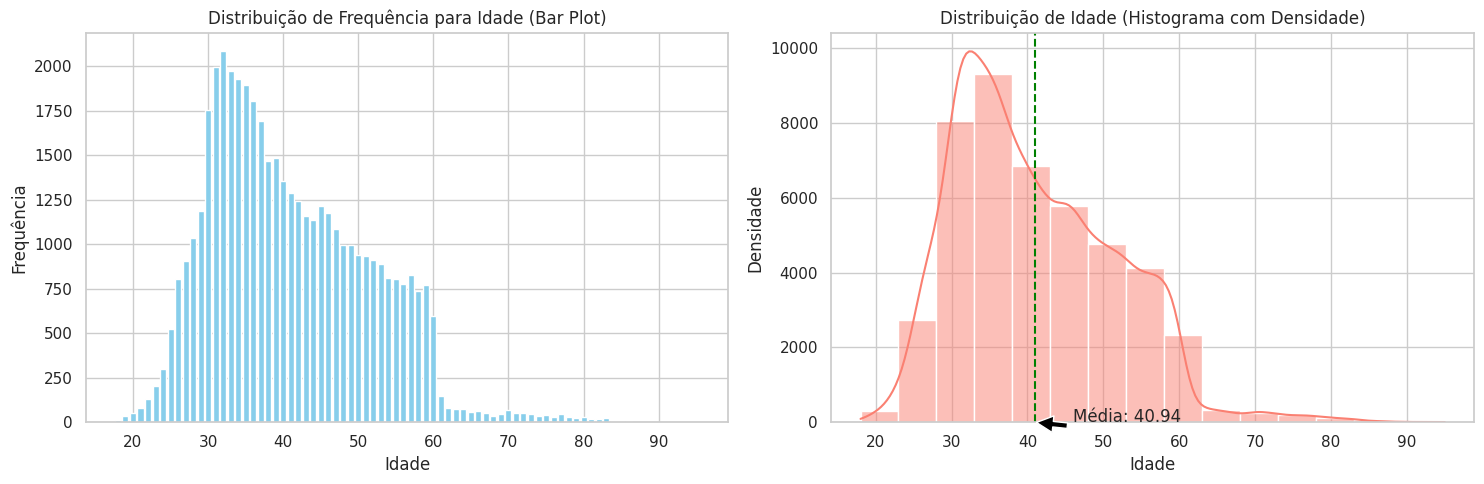

In [63]:
# Configurações de estilo
sns.set(style="whitegrid")

# Criação de uma figura com dois subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar Plot para 'age'
age_counts = dataset['age'].value_counts().sort_index()
axes[0].bar(age_counts.index, age_counts.values, color='skyblue')
axes[0].set_title('Distribuição de Frequência para Idade (Bar Plot)')
axes[0].set_xlabel('Idade')
axes[0].set_ylabel('Frequência')

# Histograma com Curva de Densidade para 'age'
sns.histplot(dataset['age'], kde=True, ax=axes[1], color='salmon', bins=np.arange(18, 96, 5))
mean_age = dataset['age'].mean()
axes[1].axvline(mean_age, color='green', linestyle='--')
axes[1].set_title('Distribuição de Idade (Histograma com Densidade)')
axes[1].set_xlabel('Idade')
axes[1].set_ylabel('Densidade')

# Adicionando anotação da média
axes[1].annotate(f'Média: {mean_age:.2f}', xy=(mean_age, 0), xytext=(mean_age + 5, 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Ajustar layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()

- **Gráfico Box-plot**

No estudo realizado, uma análise comparativa foi feita utilizando boxplots para ilustrar a distribuição de idades em relação aos resultados de uma campanha. Os resultados são categorizados em 'yes' e 'no', onde 'yes' indica que o cliente se inscreveu em um depósito a prazo, e 'no' indica que não. Essa análise é detalhadamente representada na Figura 1.

A partir desta análise, observamos que a distribuição de idades para os clientes que se inscreveram ('yes') é mais dispersa. Essa maior dispersão pode ser atribuída ao menor número de clientes que responderam positivamente, em comparação com aqueles que não se inscreveram ('no').

Posteriormente, focamos em eliminar outliers, especialmente valores que indicam idades superiores a 70 anos. Essa remoção de outliers tem um impacto limitado na área compreendida entre os quartis 0.25 e 0.75, sugerindo que a maior parte dos dados de idade está concentrada nessa faixa. Os resultados dessa operação são apresentados na Figura 2.

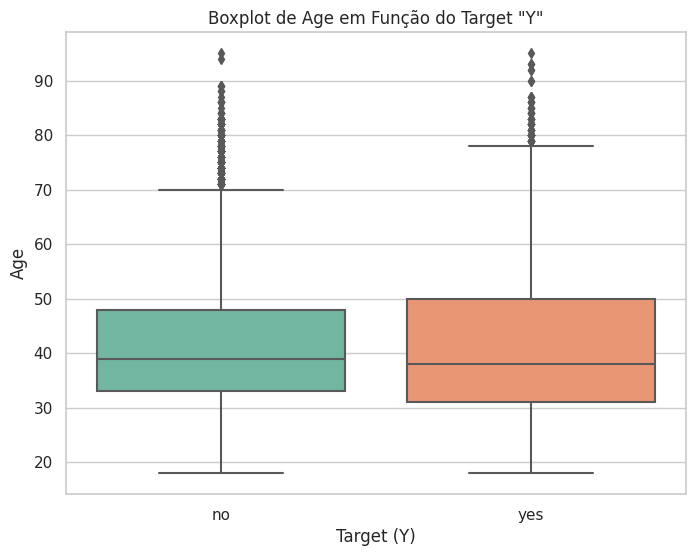

In [64]:
# Configurações de estilo
sns.set(style="whitegrid")

# Criando o boxplot de 'age' em função do target 'y'
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='age', data=dataset, palette='Set2')

# Adicionando título e rótulos
plt.title('Boxplot de Age em Função do Target "Y"')
plt.xlabel('Target (Y)')
plt.ylabel('Age')

# Mostrando o gráfico
plt.show()

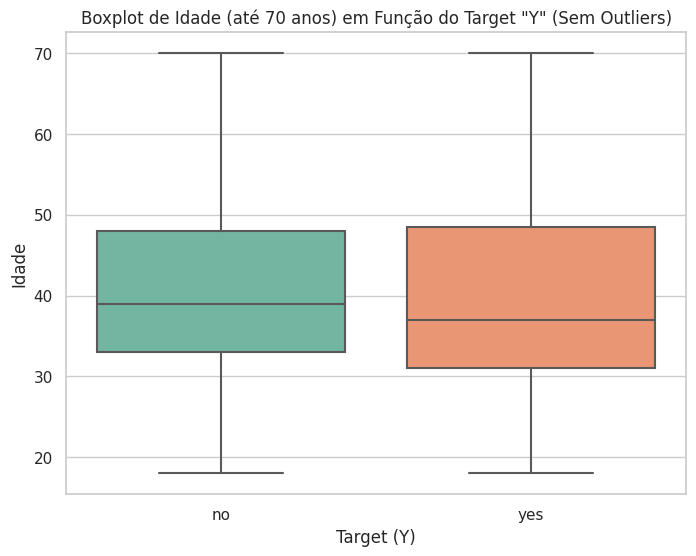

In [65]:
# Configurações de estilo
sns.set(style="whitegrid")

# Criando um boxplot de 'age' em função do target 'y' sem incluir outliers
# e limitando a idade a 70 anos ou menos
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='age', data=dataset[dataset['age'] <= 70], palette='Set2', showfliers=False)

# Adicionando título e rótulos
plt.title('Boxplot de Idade (até 70 anos) em Função do Target "Y" (Sem Outliers)')
plt.xlabel('Target (Y)')
plt.ylabel('Idade')

# Mostrando o gráfico
plt.show()

####5.3.2. Job

Em nossa análise subsequente, focamos na profissão dos clientes, uma variável categórica com 12 categorias distintas. As categorias incluem 'management', 'technician', 'entrepreneur', 'blue-collar', entre outras, conforme representado nos gráficos de pizza e barra na Figura 1 e Figura 2, respectivamente.

No gráfico de pizza (Figura 1), observamos que a categoria 'blue-collar' possui a maior parcela, representando 21,53% do total, em seguida, 'management' aparece com 20,92%. As proporções das demais categorias profissionais também são claramente visualizadas no gráfico.

Por outro lado, o bar plot (Figura 2) oferece uma visão mais direta da contagem de profissões. Aqui, vemos que 'management' lidera em termos de inscrições em depósitos a prazo, seguido por 'technician', enquanto 'blue-collar' mostra a menor inscrição nesse aspecto.

Em análises futuras, trataremos a categoria 'unknown' como valores ausentes, para refinar ainda mais a nossa compreensão do impacto da profissão nas decisões financeiras dos clientes.

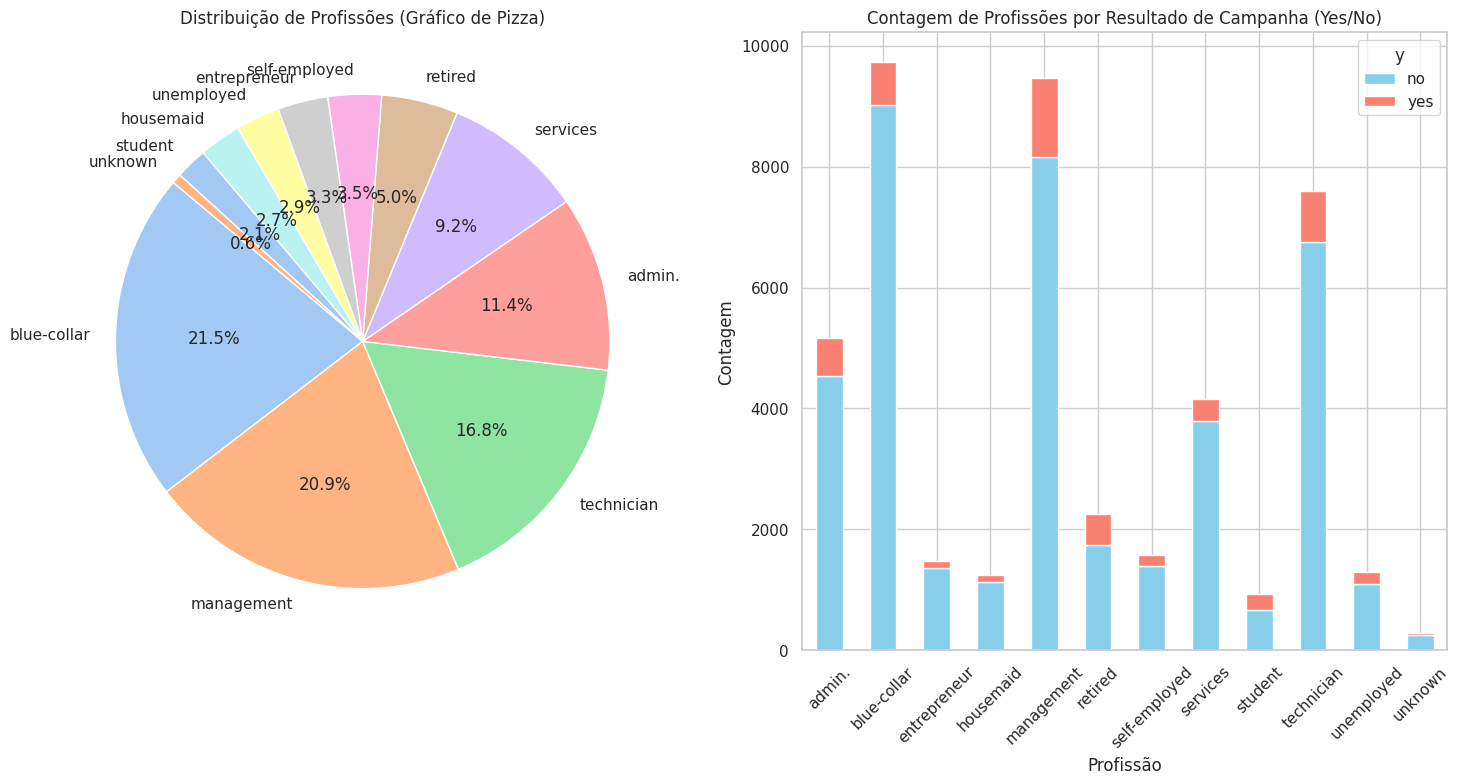

In [66]:
# Preparando os dados para o gráfico de pizza
job_counts_pie = dataset['job'].value_counts()
colors_pie = sns.color_palette('pastel')[0:len(job_counts_pie)]

# Preparando os dados para o bar plot considerando o target 'y'
job_counts_bar = dataset.groupby(['job', 'y']).size().unstack()
colors_bar = ['skyblue', 'salmon']

# Configurações de estilo
sns.set(style="whitegrid")

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Gráfico de pizza para 'job'
axes[0].pie(job_counts_pie, labels = job_counts_pie.index, autopct='%1.1f%%', colors=colors_pie, startangle=140)
axes[0].set_title('Distribuição de Profissões (Gráfico de Pizza)')

# Bar Plot para 'job' em função do target 'y'
job_counts_bar.plot(kind='bar', stacked=True, color=colors_bar, ax=axes[1])
axes[1].set_title('Contagem de Profissões por Resultado de Campanha (Yes/No)')
axes[1].set_xlabel('Profissão')
axes[1].set_ylabel('Contagem')
axes[1].tick_params(axis='x', rotation=45)

# Ajustar layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()

####5.3.3. Marital

A análise da variável 'marital', que categoriza o estado civil dos clientes, revela padrões interessantes relacionados ao sucesso da campanha. Para uma visualização detalhada, foram criados dois gráficos de pizza e um bar plot, todos considerando a resposta ao target da campanha ('yes' ou 'no').

Nas Figuras 1 e 2 (gráficos de pizza), observamos a distribuição percentual do estado civil para os clientes que responderam 'yes' e 'no' à campanha, respectivamente. Esses gráficos mostram que, tanto para 'yes' quanto para 'no', a categoria 'married' (casados) tem a maior proporção. Isso é esperado, considerando que os casados formam o maior grupo no conjunto de dados analisados.

No bar plot (Figura 9), os dados são apresentados em termos de contagem. Notavelmente, a categoria 'married' apresenta o maior número tanto de inscrições quanto de não inscrições em depósitos a prazo. A categoria 'single' (solteiros) vem em segundo lugar em termos de inscrições, enquanto 'divorced' (divorciados) apresenta as menores contagens tanto de inscrições quanto de não inscrições.

Estes gráficos proporcionam uma compreensão mais profunda da relação entre o estado civil e a resposta à campanha, destacando como diferentes grupos demográficos reagem às ofertas de depósitos a prazo.

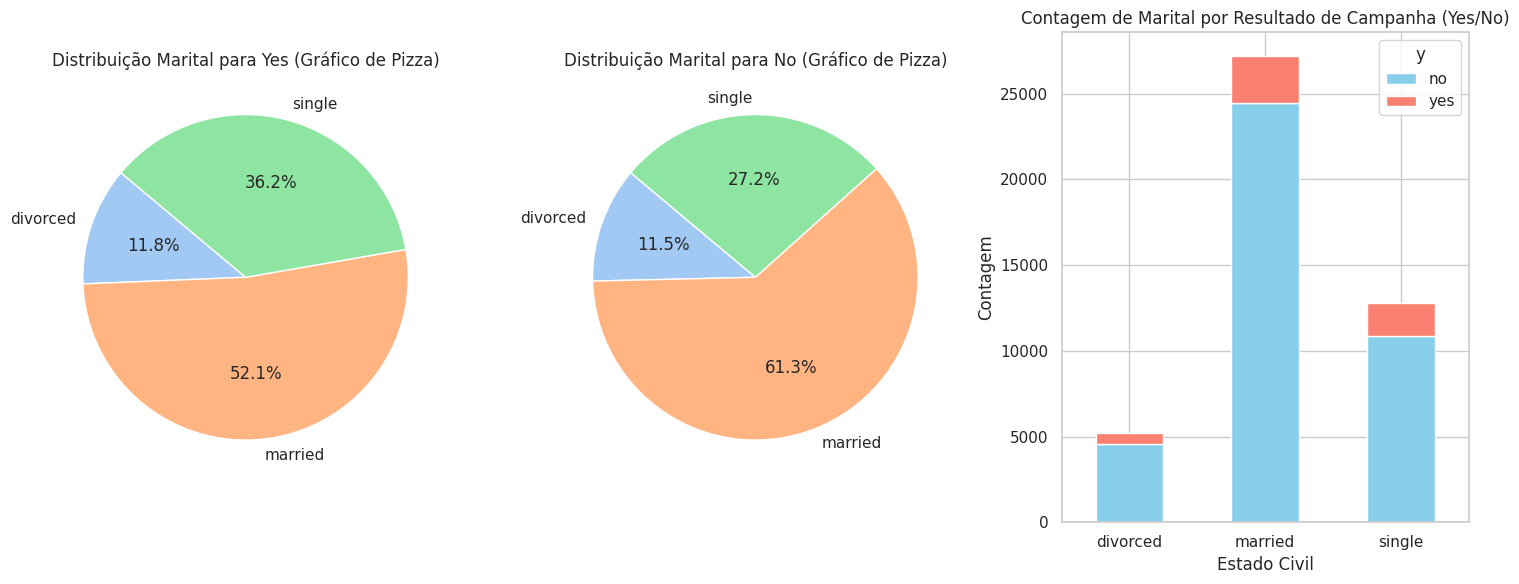

In [67]:
# Preparando os dados para os gráficos de pizza e bar plot
marital_counts = dataset.groupby(['marital', 'y']).size().unstack()

# Configurações de estilo
sns.set(style="whitegrid")

# Criando a figura e os subplots para os gráficos de pizza
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Gráficos de pizza para 'marital' divididos pelo target 'y'
colors_pizza = sns.color_palette('pastel')[0:3]

# Gráfico de pizza para 'marital' com 'y' = 'yes'
axes[0].pie(marital_counts['yes'], labels=marital_counts.index, autopct='%1.1f%%', colors=colors_pizza, startangle=140)
axes[0].set_title('Distribuição Marital para Yes (Gráfico de Pizza)')

# Gráfico de pizza para 'marital' com 'y' = 'no'
axes[1].pie(marital_counts['no'], labels=marital_counts.index, autopct='%1.1f%%', colors=colors_pizza, startangle=140)
axes[1].set_title('Distribuição Marital para No (Gráfico de Pizza)')

# Bar Plot para 'marital' em função do target 'y'
marital_counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], ax=axes[2])
axes[2].set_title('Contagem de Marital por Resultado de Campanha (Yes/No)')
axes[2].set_xlabel('Estado Civil')
axes[2].set_ylabel('Contagem')
axes[2].tick_params(axis='x', rotation=0)

# Ajustar layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()

####5.3.4. Education

Analisamos a variável 'education' no dataset, que categoriza o nível de educação dos clientes em 'primary', 'secondary', 'tertiary' e 'unknown'. O bar plot gerado (Figura 1) destaca a relação entre o nível de educação e o resultado da campanha de depósito a prazo (yes ou no).

É evidente que a educação secundária (secondary) é a mais prevalente, com o maior número de inscrições e não inscrições no depósito a prazo. Especificamente, observamos 20.752 inscrições (51,98% do total) e 2.450 não inscrições (46,32%). A educação terciária (tertiary) segue em segundo lugar, com 11.305 inscrições e 1.996 não inscrições. As categorias 'primary' e 'unknown' apresentam os menores números, tanto de inscrições quanto de não inscrições.

Esta análise revela padrões significativos na relação entre o nível educacional e a decisão financeira de se inscrever em um depósito a prazo. Em análises futuras, trataremos a categoria 'unknown' como valores ausentes para refinar ainda mais nosso entendimento desse impacto.

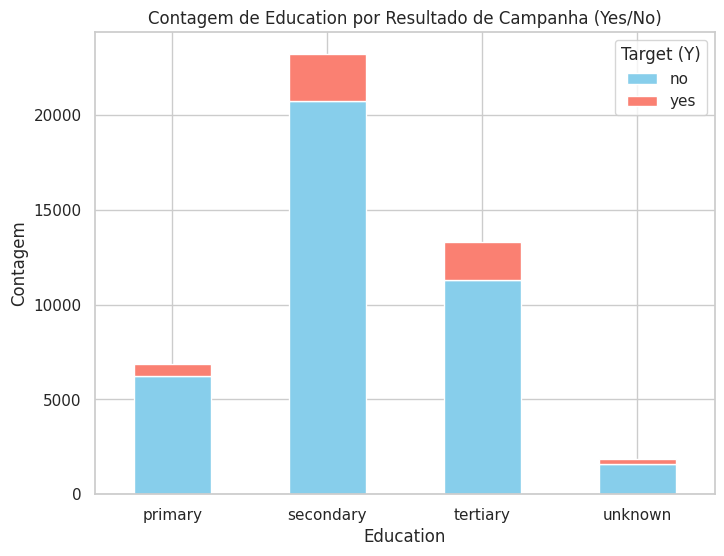

In [68]:
# Preparando os dados para o bar plot considerando a categoria 'education' e o target 'y'
education_counts = dataset.groupby(['education', 'y']).size().unstack()

# Configurações de estilo
sns.set(style="whitegrid")

# Criando o bar plot para 'education' em função do target 'y'
plt.figure(figsize=(8, 6))
education_counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], ax=plt.gca())
plt.title('Contagem de Education por Resultado de Campanha (Yes/No)')
plt.xlabel('Education')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.legend(title='Target (Y)', loc='upper right')

# Mostrar o gráfico
plt.show()

####5.3.5. Balance

Para aprofundar a análise do saldo em conta ('balance'), realizamos uma série de visualizações que incluem um scatter plot, um histograma com bins menores e dois box plots. As linhas vermelhas traçadas no scatter plot e no histograma, nos valores de 4000 e -2000, destacam os limites considerados para outliers. Essa demarcação é crucial para identificar os saldos que se desviam significativamente da tendência geral.

No scatter plot (Figura 1), observamos a distribuição de todos os saldos, com os outliers claramente demarcados pelas linhas vermelhas. Isso proporciona uma perspectiva visual da frequência e da magnitude desses valores extremos.

O histograma ajustado (Figura 2) com um tamanho de bin de 500 oferece uma visão detalhada da distribuição de frequência dos saldos, destacando a predominância de saldos mais baixos. As linhas vermelhas indicam a região onde os outliers começam a se tornar aparentes.

Os box plots (Figuras 3 e 4) complementam essa análise. O primeiro inclui todos os dados e mostra a extensão dos outliers. O segundo, filtrando os outliers, oferece uma visão mais focada da distribuição central dos saldos, excluindo os valores extremos.

Esses gráficos fornecem insights valiosos sobre a distribuição dos saldos em conta, destacando a predominância de saldos mais baixos e a natureza dos valores extremos.

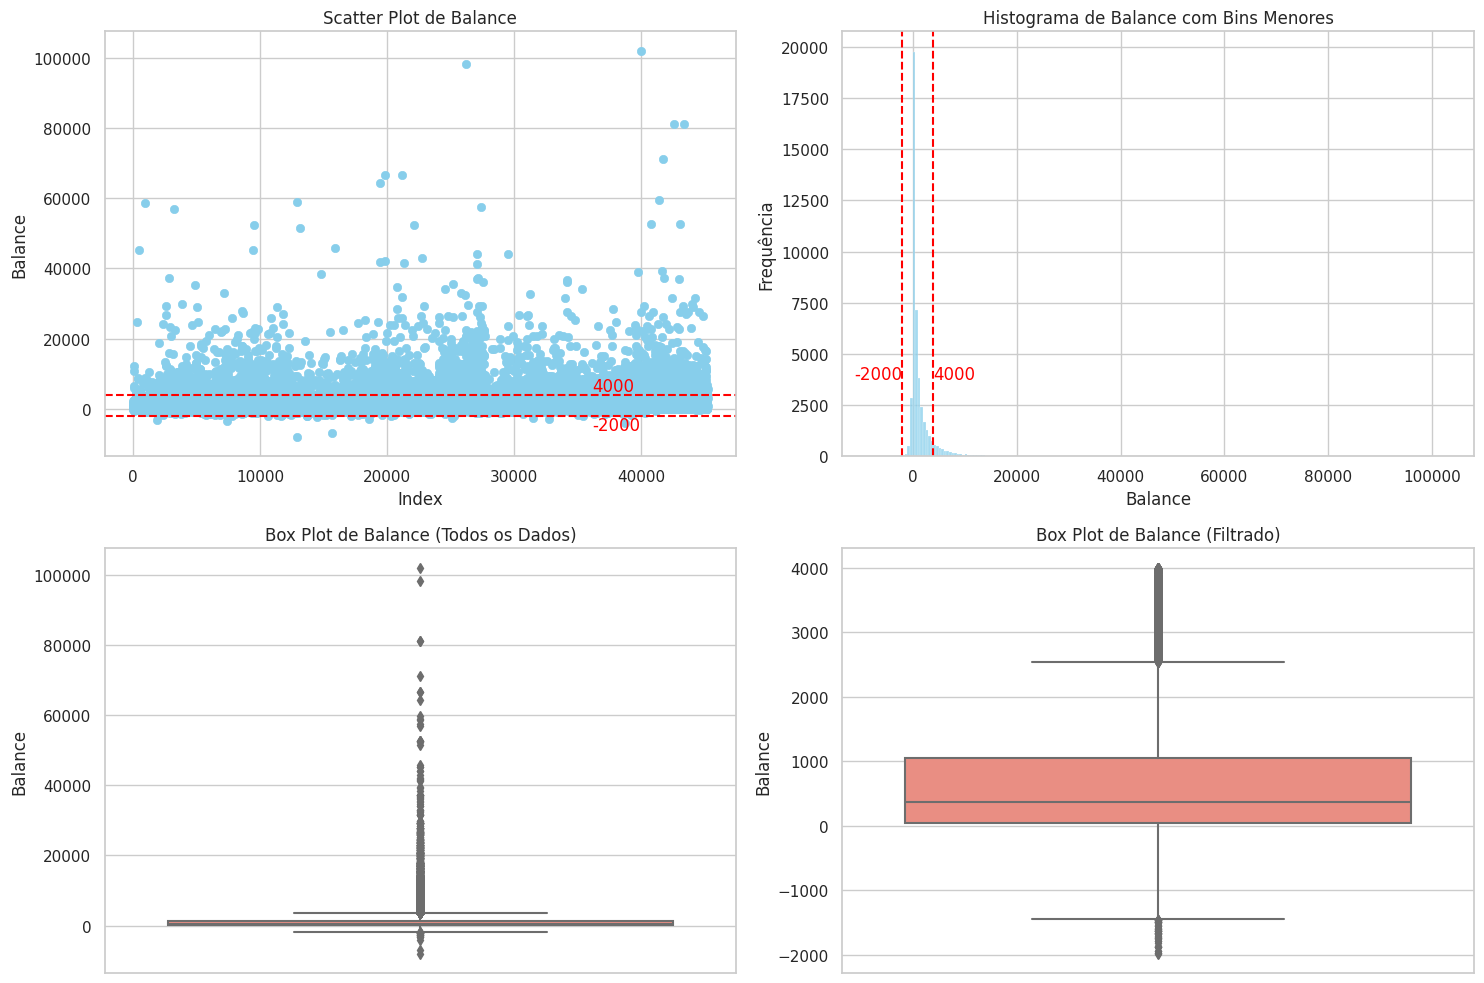

In [69]:
filtered_dataset = dataset[(dataset['balance'] <= 4000) & (dataset['balance'] >= -2000)]

# Configurações de estilo
sns.set(style="whitegrid")

# Criando a figura e os subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot para 'balance' com linhas indicativas de outliers
sns.scatterplot(data=dataset, x=np.arange(len(dataset)), y='balance', ax=axes[0, 0], color='skyblue', edgecolor=None)
axes[0, 0].axhline(4000, color='red', linestyle='--')
axes[0, 0].axhline(-2000, color='red', linestyle='--')
axes[0, 0].text(len(dataset) * 0.8, 4000, '4000', color='red', verticalalignment='bottom')
axes[0, 0].text(len(dataset) * 0.8, -2000, '-2000', color='red', verticalalignment='top')
axes[0, 0].set_title('Scatter Plot de Balance')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Balance')

# Histograma para 'balance' com linhas indicativas de outliers
bin_range = np.arange(min(dataset['balance']), max(dataset['balance']) + 500, 500)
sns.histplot(data=dataset, x='balance', bins=bin_range, kde=False, color='skyblue', ax=axes[0, 1])
axes[0, 1].axvline(4000, color='red', linestyle='--')
axes[0, 1].axvline(-2000, color='red', linestyle='--')
axes[0, 1].text(4000, 3750, '4000', color='red', horizontalalignment='left')
axes[0, 1].text(-2000, 3750, '-2000', color='red', horizontalalignment='right')
axes[0, 1].set_title('Histograma de Balance com Bins Menores')
axes[0, 1].set_xlabel('Balance')
axes[0, 1].set_ylabel('Frequência')

# Box plot para 'balance' com todos os dados
sns.boxplot(data=dataset, y='balance', ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Box Plot de Balance (Todos os Dados)')
axes[1, 0].set_ylabel('Balance')

# Box plot para 'balance' com dados filtrados
sns.boxplot(data=filtered_dataset, y='balance', ax=axes[1, 1], color='salmon')
axes[1, 1].set_title('Box Plot de Balance (Filtrado)')
axes[1, 1].set_ylabel('Balance')

# Ajustar layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()

####5.3.6. Default

Na figura 1, temos o gráfico de pizza mostrando a distribuição geral do atributo "default" no dataset. Este gráfico fornece uma visão clara da proporção de indivíduos com e sem histórico de inadimplência. A proporção de 1,8% de inadimplentes ("default: yes") sugere uma prevalência relativamente baixa de inadimplência entre os indivíduos analisados. Isso pode indicar uma tendência de boa saúde financeira na amostra ou uma política de crédito restritiva por parte das instituições financeiras.

Na figura 2, o gráfico de barras exibe os percentuais relativos das respostas do atributo-alvo "y" para cada categoria de "default". Este gráfico ajuda a entender como a inadimplência pode influenciar as respostas a esse atributo. Interessantemente, a proporção de respostas "yes" parece ser ligeiramente maior entre os indivíduos sem histórico de inadimplência ("default: no"). Isso pode indicar uma tendência de melhor aceitação ou adesão ao que é proposto pelo atributo "y" entre esse grupo.

Colocar esses gráficos lado a lado oferece uma perspectiva abrangente, permitindo uma comparação direta entre a distribuição geral de "default" e sua influência nas respostas do atributo "y".

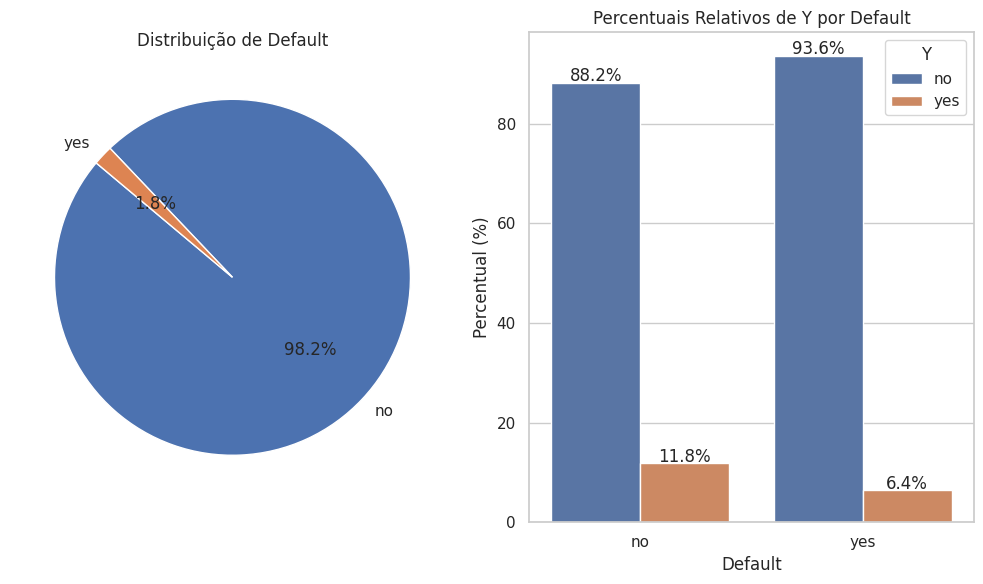

In [70]:
# Configurações de estilo
sns.set(style="whitegrid")

# Preparação dos dados para o gráfico de barras
grouped = dataset.groupby('default')['y'].value_counts(normalize=True).rename('percentage').reset_index()

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Gráfico de Pizza para 'default'
default_counts = dataset['default'].value_counts()
axes[0].pie(default_counts, labels=default_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Distribuição de Default')

# Gráfico de Barras com Percentuais Relativos para 'default' e 'y'
# Multiplicando os percentuais por 100 para ajustar ao domínio de 0 a 100
grouped['percentage'] = grouped['percentage'] * 100
sns.barplot(data=grouped, x='default', y='percentage', hue='y', ax=axes[1])
axes[1].set_title('Percentuais Relativos de Y por Default')
axes[1].set_xlabel('Default')
axes[1].set_ylabel('Percentual (%)')
axes[1].legend(title='Y', loc='upper right')

# Adicionando os valores dos percentuais no topo das barras
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.1f}%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 5),
                     textcoords = 'offset points')

# Ajustar layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()

####5.3.7. Housing

Na Figura 1, o gráfico de pizza destaca a distribuição geral do atributo "housing" no dataset. Este gráfico mostra a proporção de indivíduos que possuem (housing: yes) e não possuem (housing: no) empréstimo habitacional. A distribuição revela a predominância de indivíduos com empréstimo habitacional, refletindo talvez uma tendência de mercado ou características específicas da amostra analisada. Esta predominância pode estar associada a fatores socioeconômicos ou tendências de comportamento financeiro dentro da população estudada.

Na Figura 2, observamos o gráfico de barras que apresenta os percentuais relativos das respostas do atributo-alvo "y" para cada categoria de "housing". Esse gráfico é crucial para entender como a posse de um empréstimo habitacional influencia as respostas a este atributo. De maneira intrigante, a proporção de respostas "yes" no atributo-alvo "y" parece ser ligeiramente mais alta entre os indivíduos que não possuem empréstimo habitacional (housing: no). Isso sugere que a ausência de um empréstimo habitacional pode estar associada a uma maior disposição ou capacidade de responder afirmativamente a propostas ou iniciativas representadas pelo atributo "y". Esta observação pode indicar diferenças na estabilidade financeira ou nas prioridades financeiras entre os dois grupos.

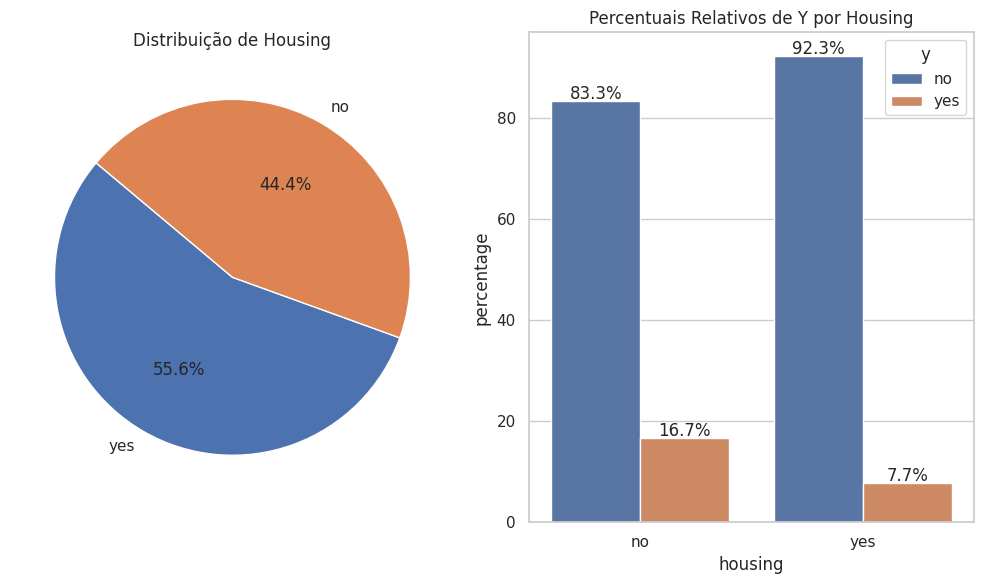

In [71]:
# Configurações de estilo
sns.set(style="whitegrid")

# Análise e preparação dos dados para gráficos
housing_counts = dataset['housing'].value_counts()
housing_grouped = dataset.groupby('housing')['y'].value_counts(normalize=True).rename('percentage').reset_index()
housing_grouped['percentage'] = housing_grouped['percentage'] * 100

# Gráfico de Pizza
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].pie(housing_counts, labels=housing_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Distribuição de Housing')

# Gráfico de Barras com Percentuais Relativos para 'housing' e 'y'
sns.barplot(data=housing_grouped, x='housing', y='percentage', hue='y', ax=axes[1])
axes[1].set_title('Percentuais Relativos de Y por Housing')
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Ajustar layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()

####5.3.8. Loan

Na Figura 1, o gráfico de pizza ilustra a distribuição do atributo "loan" no dataset. Este gráfico fornece uma visão clara da proporção de indivíduos com e sem empréstimos pessoais. A maior parte dos indivíduos não possui empréstimos pessoais ("loan: no"), o que pode refletir uma preferência ou situação financeira que os leva a evitar dívidas adicionais ou pode indicar uma política de crédito mais restritiva.

Na Figura 2, o gráfico de barras mostra os percentuais relativos das respostas do atributo-alvo "y" para cada categoria de "loan". Esta visualização é essencial para entender como a presença de um empréstimo pessoal afeta as respostas ao atributo "y". Notavelmente, a proporção de respostas "yes" parece ser maior entre os indivíduos sem empréstimos pessoais ("loan: no"). Esta tendência sugere que a ausência de empréstimos pessoais pode estar associada a uma maior abertura ou capacidade de responder positivamente às propostas ou solicitações representadas pelo atributo "y". Tal observação pode indicar um nível de estabilidade financeira ou prioridades financeiras diferentes entre os que possuem e os que não possuem empréstimos pessoais.

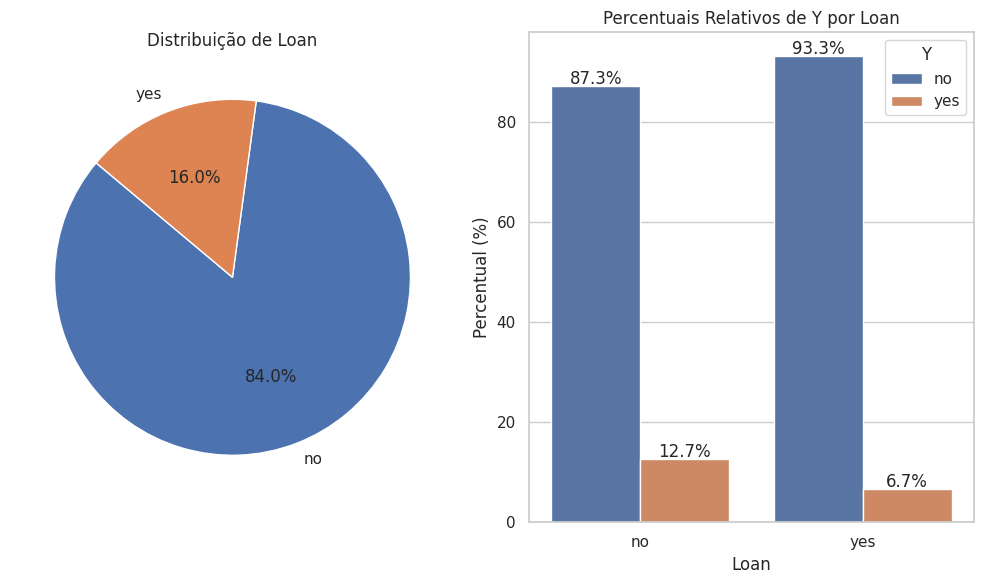

In [72]:
# Configurações de estilo
sns.set(style="whitegrid")

# Contagem de valores para o atributo 'loan'
loan_counts = dataset['loan'].value_counts()

# Percentuais relativos para 'loan' e 'y'
loan_grouped = dataset.groupby('loan')['y'].value_counts(normalize=True).rename('percentage').reset_index()
loan_grouped['percentage'] = loan_grouped['percentage'] * 100  # Convertendo para percentual

# Criando a figura e os subplots para os gráficos
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Gráfico de Pizza para 'loan'
axes[0].pie(loan_counts, labels=loan_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Distribuição de Loan')

# Gráfico de Barras com Percentuais Relativos para 'loan' e 'y'
sns.barplot(data=loan_grouped, x='loan', y='percentage', hue='y', ax=axes[1])
axes[1].set_title('Percentuais Relativos de Y por Loan')
axes[1].set_xlabel('Loan')
axes[1].set_ylabel('Percentual (%)')
axes[1].legend(title='Y', loc='upper right')

# Adicionando os valores dos percentuais no topo das barras
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.1f}%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 5),
                     textcoords = 'offset points')

# Ajustar layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()

####5.3.9. Day, Month

Nos gráficos apresentados, exploramos a distribuição das respostas ao atributo-alvo "y" (subscrição ao depósito a prazo do banco) em relação aos atributos "month" e "day".

- Distribuição de Y por Mês (Figura Superior), este gráfico mostra o número de clientes que se inscreveram ("yes") e que não se inscreveram ("no") no depósito a prazo do banco, mês a mês. É evidente que maio é o mês com o maior número de inscrições e não inscrições, seguido por julho e agosto. Esta observação sugere que campanhas de marketing direto realizadas em maio tendem a alcançar mais clientes, embora isso não implique necessariamente uma maior taxa de sucesso;

- Distribuição de Y por Dia (Figura Inferior), o segundo gráfico detalha a distribuição diária das respostas ao atributo "y". Aqui, observamos a contagem de clientes que se inscreveram ou não no depósito a prazo em cada dia do mês. Este gráfico ajuda a identificar quais dias tendem a ter uma maior ou menor adesão à oferta do banco.

Embora os atributos "day" e "month" proporcionem uma gravação precisa dos dados e clareza, eles parecem ter um impacto limitado na mudança do número de clientes que se inscreveram ou não durante a campanha. Portanto, podemos ser tentados a considerar esses atributos como menos importantes na análise geral, focando mais em variáveis que demonstram uma correlação mais direta com o sucesso da campanha. Essa percepção é crucial para o direcionamento eficaz de estratégias de marketing e para a compreensão do comportamento do cliente em diferentes períodos do ano.

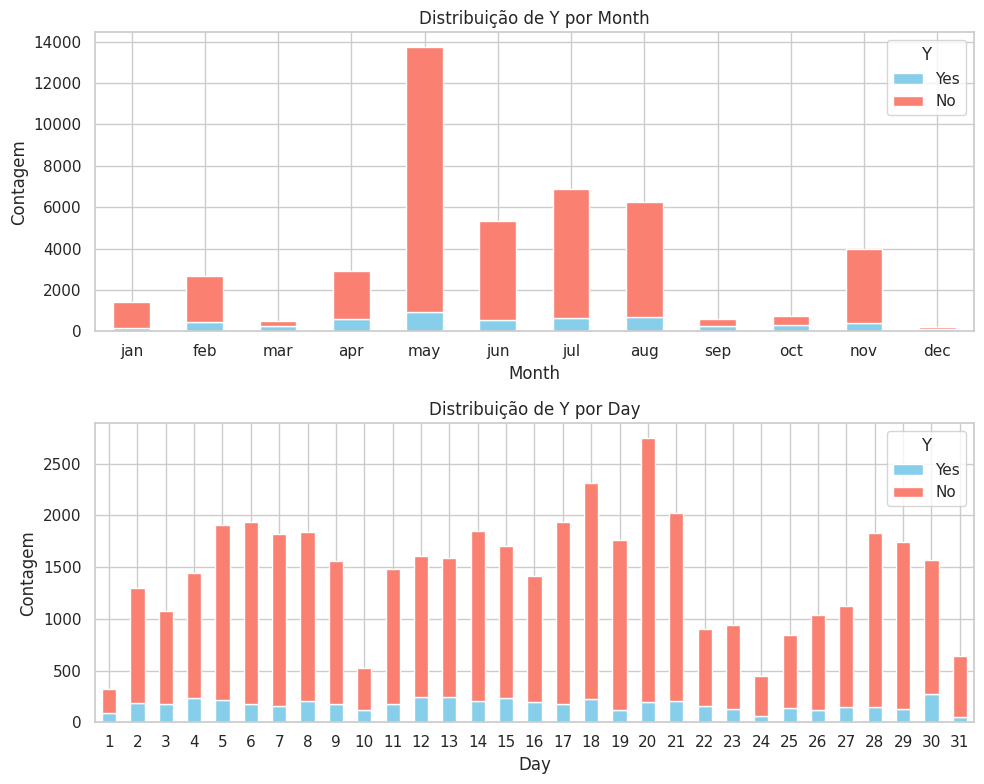

In [73]:
# Configurações de estilo
sns.set(style="whitegrid")

# Convertendo as colunas 'y' em valores numéricos para facilitar a agregação
dataset['y_numeric'] = dataset['y'].map({'yes': 1, 'no': 0})

# Agrupando os dados por 'month' e 'day' e calculando a soma e contagem total para 'y'
month_summary = dataset.groupby('month')['y_numeric'].agg(['sum', 'count']).reset_index()
day_summary = dataset.groupby('day')['y_numeric'].agg(['sum', 'count']).reset_index()

# Calculando o número de 'no' como a diferença entre a contagem total e a soma de 'yes'
month_summary['no'] = month_summary['count'] - month_summary['sum']
day_summary['no'] = day_summary['count'] - day_summary['sum']

# Mapeando os nomes dos meses para números para ordenação
month_order = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
month_summary['month_num'] = month_summary['month'].map(month_order)

# Ordenando os dados por mês
month_summary_sorted = month_summary.sort_values('month_num')

# Criando a figura e os subplots para os gráficos corrigidos
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico de Barra para 'month'
month_summary_sorted.plot(x='month', y=['sum', 'no'], kind='bar', stacked=True, ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Distribuição de Y por Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Contagem')
axes[0].legend(title='Y', labels=['Yes', 'No'])
axes[0].set_xticklabels(month_summary_sorted['month'], rotation=0)

# Gráfico de Barra para 'day'
day_summary.plot(x='day', y=['sum', 'no'], kind='bar', stacked=True, ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('Distribuição de Y por Day')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Contagem')
axes[1].legend(title='Y', labels=['Yes', 'No'])
axes[1].set_xticklabels(day_summary['day'], rotation=0)

# Ajustar layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()

####5.3.10. Duration

O atributo 'duration', de natureza numérica, varia entre 0 e 4918 (segundos ou unidade de tempo correspondente). Este atributo exerce uma influência significativa sobre o alvo 'y'. Por exemplo, uma 'duration' igual a zero indica que não houve contato no período considerado, ou seja, 'y' = 'no'. Vale ressaltar que a 'duration' só é conhecida após a realização de uma chamada, e ao término desta, o resultado 'y' é determinado. Assim, a duração de uma chamada é um indicador crucial, conhecido ao final do contato.

Embora 'duration' seja essencial para manter registros precisos e garantir clareza, sua utilidade é limitada no contexto de um modelo preditivo realista. Isso ocorre porque, antes de uma chamada ser feita, a duração é desconhecida, e modelos preditivos idealmente dependem de variáveis conhecidas previamente. Portanto, embora 'duration' forneça insights valiosos sobre o comportamento das chamadas, ela deve ser considerada com cautela ou até excluída se o objetivo for desenvolver um modelo preditivo realista e aplicável antes do início das chamadas.

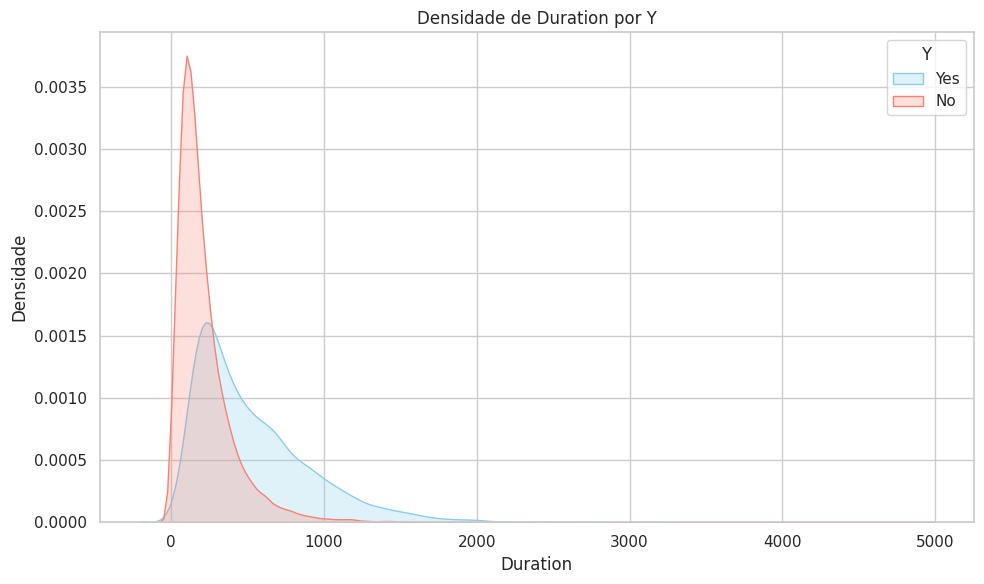

In [74]:
# Configurações de estilo
sns.set(style="whitegrid")

# Filtrando os dados por 'y'
duration_yes = dataset[dataset['y'] == 'yes']['duration']
duration_no = dataset[dataset['y'] == 'no']['duration']

# Criando o gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(duration_yes, shade=True, color="skyblue", label="Yes")
sns.kdeplot(duration_no, shade=True, color="salmon", label="No")
plt.title('Densidade de Duration por Y')
plt.xlabel('Duration')
plt.ylabel('Densidade')
plt.legend(title='Y')

# Ajustar layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

####5.3.11. Contact

O atributo 'contact', de natureza categórica, classifica o meio de contato utilizado durante a campanha, com as categorias sendo 'cellular', 'telephone' e 'unknown'. O gráfico mosaico, conforme mostrado na figura abaixo, ilustra como os clientes foram contatados e quantifica aqueles que foram abordados por celular, telefone ou meios desconhecidos, destacando também aqueles que se inscreveram ou não no depósito a prazo do banco.

É notável no gráfico que a quantidade de clientes que não se inscreveram no depósito a prazo, independentemente do meio de contato, supera significativamente aqueles que se inscreveram. Esse padrão é consistente em todas as categorias de 'contact'. Essa observação sugere que, embora o meio de contato seja um fator na condução das campanhas, ele pode não ser um determinante crítico da taxa de sucesso da inscrição. Portanto, o foco pode ser mais efetivamente direcionado para outros aspectos da campanha, como a mensagem transmitida ou a segmentação do cliente. ​

<Figure size 1200x600 with 0 Axes>

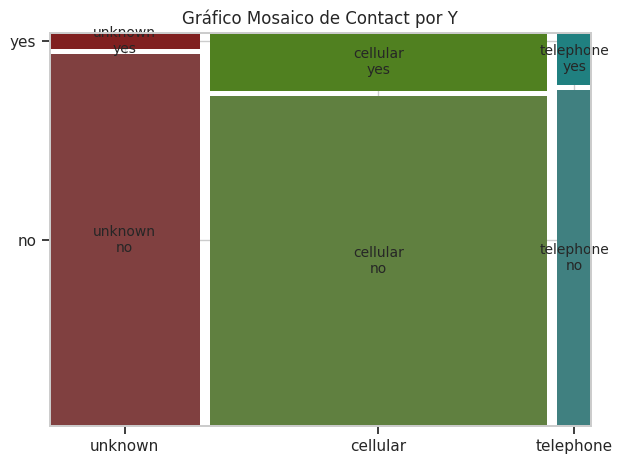

In [75]:
# Configurações de estilo
sns.set(style="whitegrid")

# Criando o gráfico de mosaico
plt.figure(figsize=(12, 6))
mosaic(dataset, ['contact', 'y'], gap=0.02)
plt.title('Gráfico Mosaico de Contact por Y')

# Ajustar layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

####5.3.12. Poutcome

Nesta seção, analisamos outro atributo significativo denominado "Poutcome", que é categórico e apresenta as categorias 'failure' (falha), 'other' (outro), 'success' (sucesso) e 'unknown' (desconhecido). A Figura abaixo ilustra os resultados das campanhas de marketing de uma instituição bancária portuguesa, incluindo os desfechos mencionados.

O gráfico revela que a categoria 'failure' nos resultados das campanhas anteriores está associada a um grande número de clientes que recusaram se inscrever no depósito a prazo ou em políticas do banco, em comparação àqueles que se inscreveram. Por outro lado, o 'success' nas campanhas anteriores indica uma adesão significativamente maior dos clientes ao depósito a prazo do banco, em relação ao número daqueles que não se inscreveram.

Quanto à categoria 'other', observa-se que o número de clientes que não se inscreveu no depósito a prazo do banco é maior do que o número dos que se inscreveram. Já o resultado 'unknown', que representa os desfechos incertos das campanhas anteriores, sugere que a quantidade de clientes que não se inscreveu foi consideravelmente maior do que aqueles que se inscreveram no depósito a prazo do banco. Esse resultado pode ser interpretado como uma estimativa do sucesso das campanhas, onde a falta de adesão prevalece.

Essas observações são cruciais para entender a eficácia das estratégias de marketing do banco e fornecem insights valiosos para o planejamento de futuras campanhas. A análise dos resultados passados pode ser um indicador chave para aprimorar abordagens e aumentar a eficiência das iniciativas de marketing.

<Figure size 1200x600 with 0 Axes>

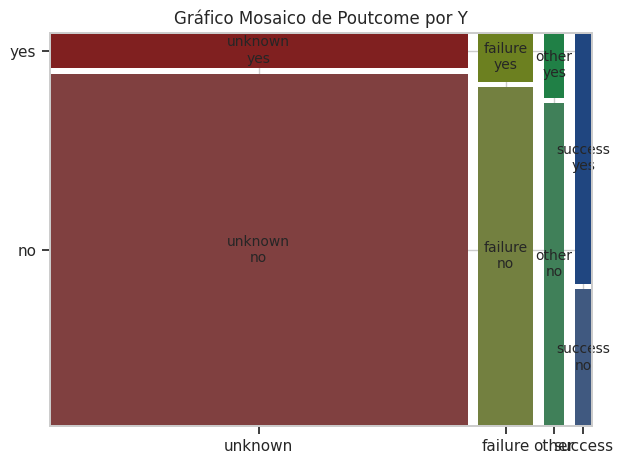

In [76]:
# Configurações de estilo
sns.set(style="whitegrid")

# Criando o gráfico de mosaico
plt.figure(figsize=(12, 6))
mosaic(dataset, ['poutcome', 'y'], gap=0.02)
plt.title('Gráfico Mosaico de Poutcome por Y')

# Ajustar layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

####5.3.13. Campaign

O atributo "campaign", de natureza numérica, varia de 1 a 63 e representa o número total de contatos realizados pela instituição bancária portuguesa durante suas campanhas de marketing. A Figura apresenta a distribuição das respostas ao depósito a prazo do banco em relação ao número de contatos feitos.

O gráfico de barras mostra uma assimetria à direita, indicando que a maioria dos clientes foi contatada poucas vezes. Além disso, observa-se que o número de clientes que não se inscreveram no depósito a prazo do banco ("no") é predominantemente maior do que aqueles que se inscreveram ("yes"), especialmente em campanhas com menor número de contatos. Essa tendência sugere que campanhas com contatos mais frequentes podem não necessariamente levar a uma maior taxa de inscrição, destacando a importância de estratégias de contato eficazes e bem planejadas para otimizar os resultados das campanhas de marketing. ​

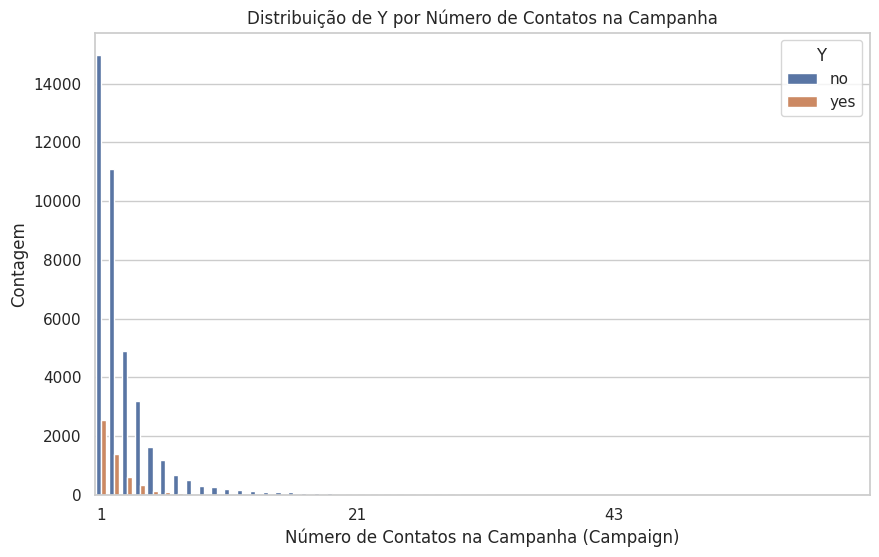

In [77]:
# Configurações de estilo
sns.set(style="whitegrid")

# Preparando os dados para o gráfico
campaign_grouped = dataset.groupby('campaign')['y'].value_counts().rename('count').reset_index()

# Criando o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=campaign_grouped, x='campaign', y='count', hue='y')
plt.title('Distribuição de Y por Número de Contatos na Campanha')
plt.xlabel('Número de Contatos na Campanha (Campaign)')
plt.ylabel('Contagem')
plt.legend(title='Y')
plt.xticks([0, 20, 40, 60])  # Ajustando os ticks no eixo x para mostrar apenas 0, 20, 40, 60

# Mostrar o gráfico
plt.show()

####5.3.14. Pdays

Abaixo estão os dois gráficos apresentados lado a lado para comparação:

- À esquerda: O gráfico mosaico mostra a proporção de registros no dataset com "pdays" igual a -1 em comparação aos outros valores de "pdays". Isso destaca a predominância de clientes que não foram contatados anteriormente.

- À direita: O gráfico de barras representa a distribuição do atributo-alvo "y" em relação a "pdays" (excluindo -1 e < 600), com "pdays" agrupado em intervalos de 50 dias. Este gráfico mostra como a frequência de contato anterior (dentro de determinados intervalos de tempo) influencia as respostas dos clientes.

O atributo "pdays" representa o número de dias que se passaram após o último contato do cliente em uma campanha anterior. Um aspecto notável nos dados é a presença significativa do valor -1, que indica clientes que não foram contatados anteriormente.

Observou-se uma diferença na taxa de aceitação do produto (depósito a prazo) entre clientes com e sem contato anterior. Clientes sem contatos anteriores mostraram uma tendência menor em aceitar o produto comparados àqueles com algum histórico de contato.

Um pequeno segmento de clientes, que representa uma fração mínima do total (0.12%), teve um número excepcionalmente alto de dias desde o último contato (> 600). A taxa de aceitação do produto nesse grupo foi moderada, sugerindo que um número muito alto de dias após o contato pode não ser proporcionalmente eficaz. Esse grupo deverá ser considerado de "outliers".

Quando focamos na análise de "pdays" excluindo o valor -1, observamos como os dias desde o último contato influenciam as respostas atuais ao atributo-alvo "y" (subscrição ao depósito a prazo). Essa análise exclui os casos onde não houve contato anterior, permitindo avaliar o impacto da frequência de contato sobre a decisão do cliente.

Neste contexto, percebemos que:

- Influência na Decisão de Subscrição: A frequência com que os clientes foram contatados anteriormente parece ter uma influência relevante nas respostas atuais. Por exemplo, períodos mais curtos desde o último contato podem indicar um relacionamento mais ativo com o cliente, o que pode estar correlacionado com uma maior probabilidade de subscrição.

- Padrões Temporais: A distribuição de "pdays" (excluindo -1) em relação a "y" revela padrões temporais que podem ser cruciais para entender o comportamento do cliente. Por exemplo, um intervalo mais longo desde o último contato pode estar associado a uma menor probabilidade de subscrição, sugerindo a importância de manter um contato regular com os clientes.

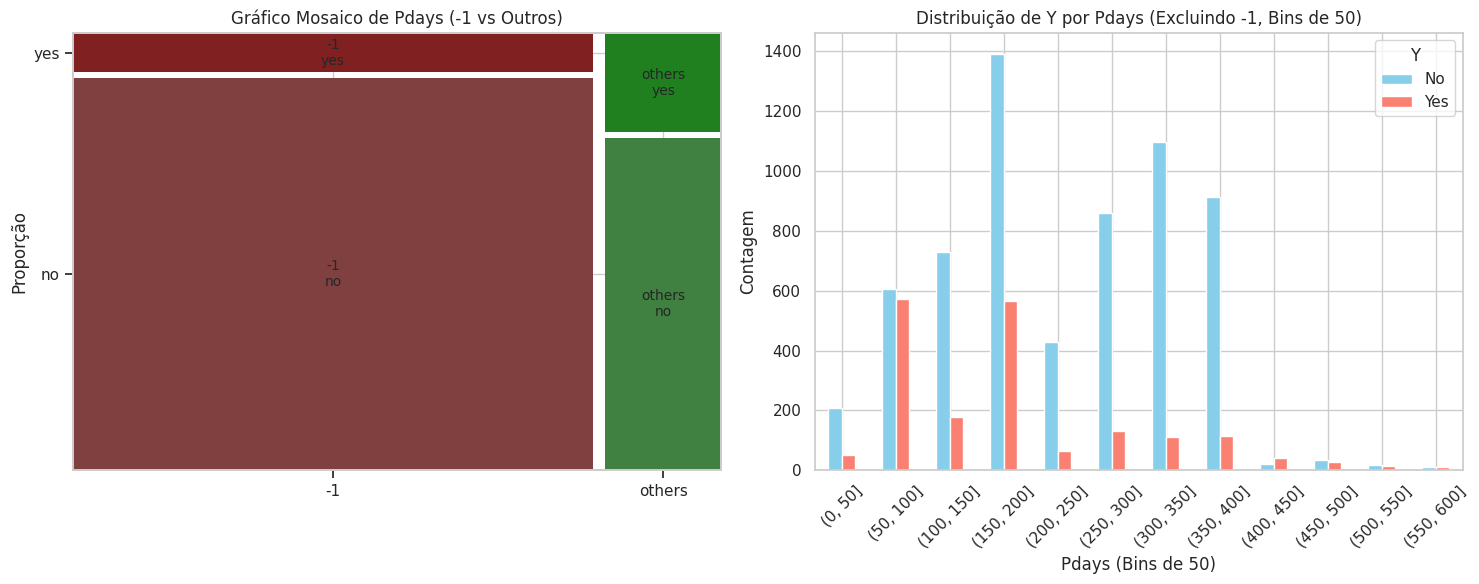

In [78]:
# Configurações de estilo
sns.set(style="whitegrid")

# Categorizando 'pdays' em dois grupos: -1 e outros para o gráfico mosaico
dataset['pdays_cat_mosaic'] = ['-1' if pdays == -1 else 'others' for pdays in dataset['pdays']]

# Preparando os dados para o gráfico de barras, excluindo 'pdays' = -1 e criando bins de 50
filtered_pdays = dataset[(dataset['pdays'] > -1) & (dataset['pdays'] < 600)]
max_pdays = filtered_pdays['pdays'].max()
bins = range(0, max_pdays + 50, 50)
filtered_pdays['pdays_cat'] = pd.cut(filtered_pdays['pdays'], bins=bins)
pdays_grouped = filtered_pdays.groupby(['pdays_cat', 'y']).size().unstack().fillna(0).reset_index()

# Criando a figura com subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico Mosaico
mosaic(dataset, ['pdays_cat_mosaic', 'y'], gap=0.02, ax=axes[0])
axes[0].set_title('Gráfico Mosaico de Pdays (-1 vs Outros)')
axes[0].set_ylabel('Proporção')

# Gráfico de Barras
pdays_grouped.plot(kind='bar', x='pdays_cat', stacked=False, color=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title('Distribuição de Y por Pdays (Excluindo -1, Bins de 50)')
axes[1].set_xlabel('Pdays (Bins de 50)')
axes[1].set_ylabel('Contagem')
axes[1].legend(title='Y', labels=['No', 'Yes'])
axes[1].tick_params(axis='x', rotation=45)

# Mostrar os gráficos
plt.tight_layout()
plt.show()


####5.3.15. Previous

Abaixo estão os dois gráficos apresentados lado a lado para comparação:

- À esquerda: O gráfico mosaico categoriza 'previous' em dois grupos (sem contato anterior e com contato anterior) e visualiza claramente a distribuição dos clientes nessas categorias, destacando as diferenças nas taxas de aceitação do produto.

- À direita: O gráfico de barras analisa a relação entre o histórico de contato e a decisão do cliente em um intervalo moderado de contatos anteriores, usando intervalos específicos. Ele oferece insights sobre como diferentes níveis de contato anterior influenciam a decisão do cliente.

Observou-se uma diferença na taxa de aceitação do produto (depósito a prazo) entre clientes com e sem histórico de contato anterior. Clientes sem contatos anteriores mostraram uma tendência menor em aceitar o produto comparados àqueles com algum histórico de contato. Isso indica que contatos repetidos podem ser mais eficazes para o sucesso da campanha.

Um pequeno segmento de clientes, que representa uma fração mínima do total (0.12%), teve um número excepcionalmente alto de contatos anteriores (> 20). A taxa de aceitação do produto nesse grupo foi moderada, sugerindo que um número excessivamente alto de contatos pode não ser proporcionalmente eficaz. Esse grupo deverá ser considerado de "outliers".

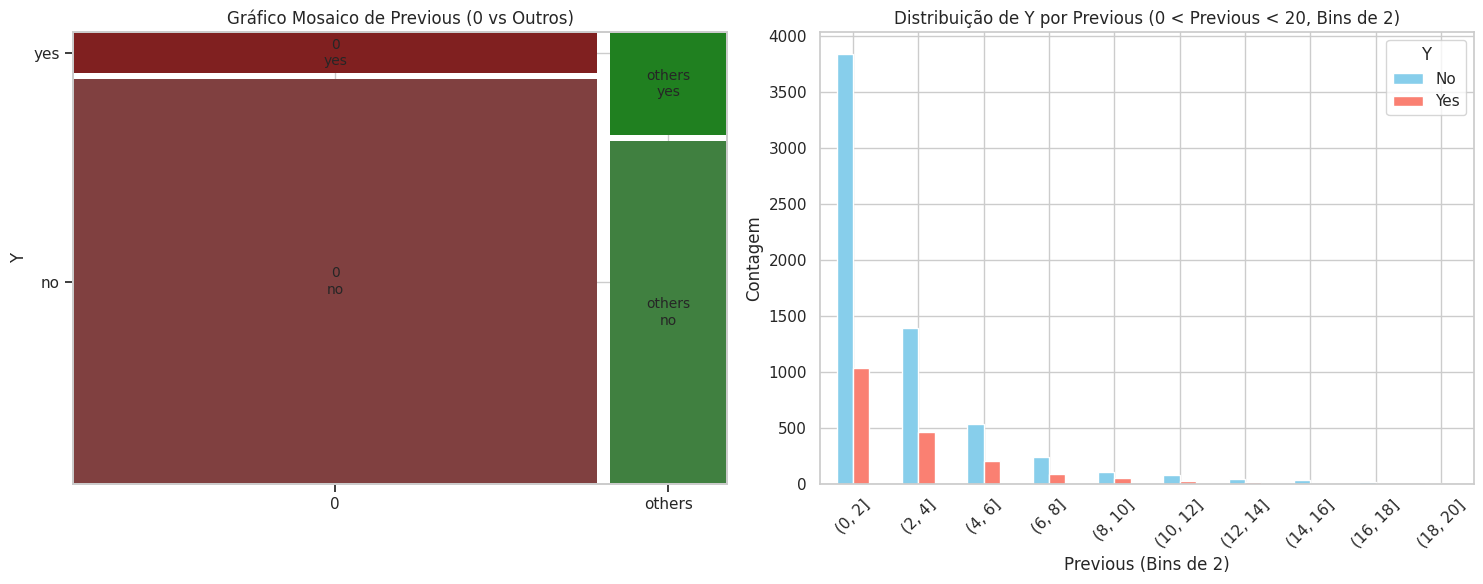

In [79]:
# Configurações de estilo
sns.set(style="whitegrid")

# Categorizando 'previous' em dois grupos: 0 e outros para o gráfico mosaico
dataset['previous_cat_mosaic'] = ['0' if previous == 0 else 'others' for previous in dataset['previous']]

# Preparando os dados para o gráfico de barras, incluindo 0 <'previous' < 20 e criando bins
bins_size = 2
filtered_previous = dataset[(dataset['previous'] > 0) & (dataset['previous'] < 20)]
max_previous = filtered_previous['previous'].max()
bins = range(0, max_previous + bins_size, bins_size)
filtered_previous['previous_cat'] = pd.cut(filtered_previous['previous'], bins=bins)
previous_grouped = filtered_previous.groupby(['previous_cat', 'y']).size().unstack().fillna(0).reset_index()

# Criando a figura com subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico Mosaico
mosaic(dataset, ['previous_cat_mosaic', 'y'], gap=0.02, ax=axes[0])
axes[0].set_title('Gráfico Mosaico de Previous (0 vs Outros)')
axes[0].set_ylabel('Y')

# Gráfico de Barras
previous_grouped.plot(kind='bar', x='previous_cat', stacked=False, color=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title(f'Distribuição de Y por Previous (0 < Previous < 20, Bins de {bins_size})')
axes[1].set_xlabel(f'Previous (Bins de {bins_size})')
axes[1].set_ylabel('Contagem')
axes[1].legend(title='Y', labels=['No', 'Yes'])
axes[1].tick_params(axis='x', rotation=45)

# Mostrar os gráficos
plt.tight_layout()
plt.show()


###5.4. Visualização multimodal

O gráfico de calor abaixo mostra a correlação entre as variáveis numéricas do conjunto de dados e a variável alvo 'y', que foi convertida para valores numéricos (0 para 'no', 1 para 'yes'). O gráfico utiliza uma escala de cores 'RdBu', onde tons de vermelho indicam uma correlação negativa e tons de azul indicam uma correlação positiva. Cada célula é anotada com o coeficiente de correlação, que varia de -1 a +1, indicando a força e a direção da relação linear entre as variáveis. Este gráfico é útil para identificar variáveis numéricas que podem ter uma influência significativa sobre a decisão do cliente, sendo uma ferramenta importante para análises preditivas e compreensão dos fatores-chave no conjunto de dados.

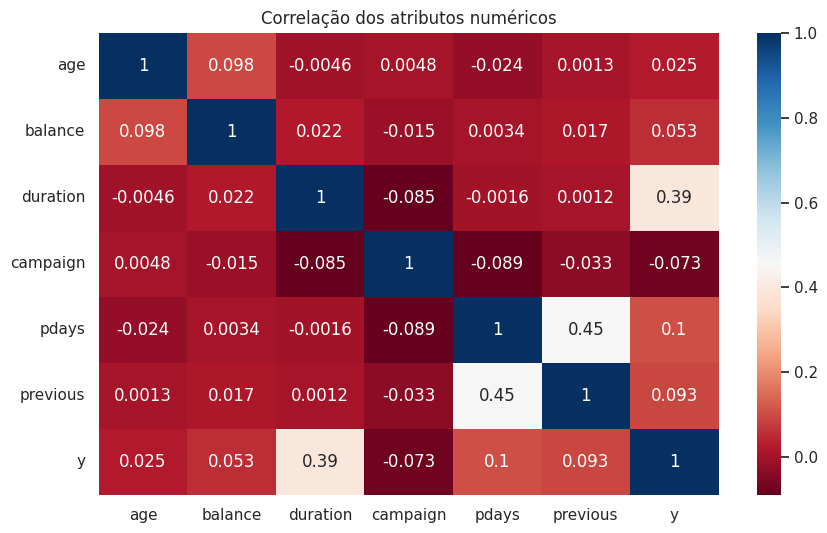

In [80]:
# separando os atributos numéricos com o target 'y'
df_selected = dataset[[*col_num, *col_y]].copy()

# convertendo a variável alvo para numérica
df_selected['y'] = df_selected['y'].map({'no': 0, 'yes': 1})

# Criando um gráfico de calor
plt.figure(figsize=(10, 6))
sns.heatmap(df_selected.corr(), annot=True, cmap='RdBu')
plt.title("Correlação dos atributos numéricos")
plt.show()

O próximo heatmap apresenta a correlação entre a variável alvo 'y' e outras variáveis do conjunto de dados, incluindo variáveis categóricas convertidas para formatos numéricos. A conversão foi realizada utilizando o método cat.codes, que atribui um código numérico único a cada categoria dentro de uma variável categórica. Essa conversão é crucial para incluir variáveis categóricas na matriz de correlação, já que a correlação de Pearson, utilizada por padrão, só é aplicável a variáveis numéricas contínuas.

Os valores no heatmap representam a força e a direção da relação linear entre as variáveis e 'y'. Valores positivos indicam uma correlação positiva, onde um aumento em uma variável está associado a um aumento em 'y', e valores negativos indicam o oposto. É importante notar que a codificação numérica das variáveis categóricas para incluí-las na análise de correlação pode introduzir uma ordem artificial, que pode não representar relações lineares significativas na realidade. Portanto, a interpretação dessas correlações, especialmente para variáveis categóricas, deve ser realizada com cautela e consideração do contexto de cada variável.

Este gráfico fornece uma visão geral útil das potenciais relações lineares no conjunto de dados e pode ser um ponto de partida para análises mais aprofundadas, mas é essencial considerar as limitações da metodologia utilizada na conversão de variáveis categóricas para o formato numérico.

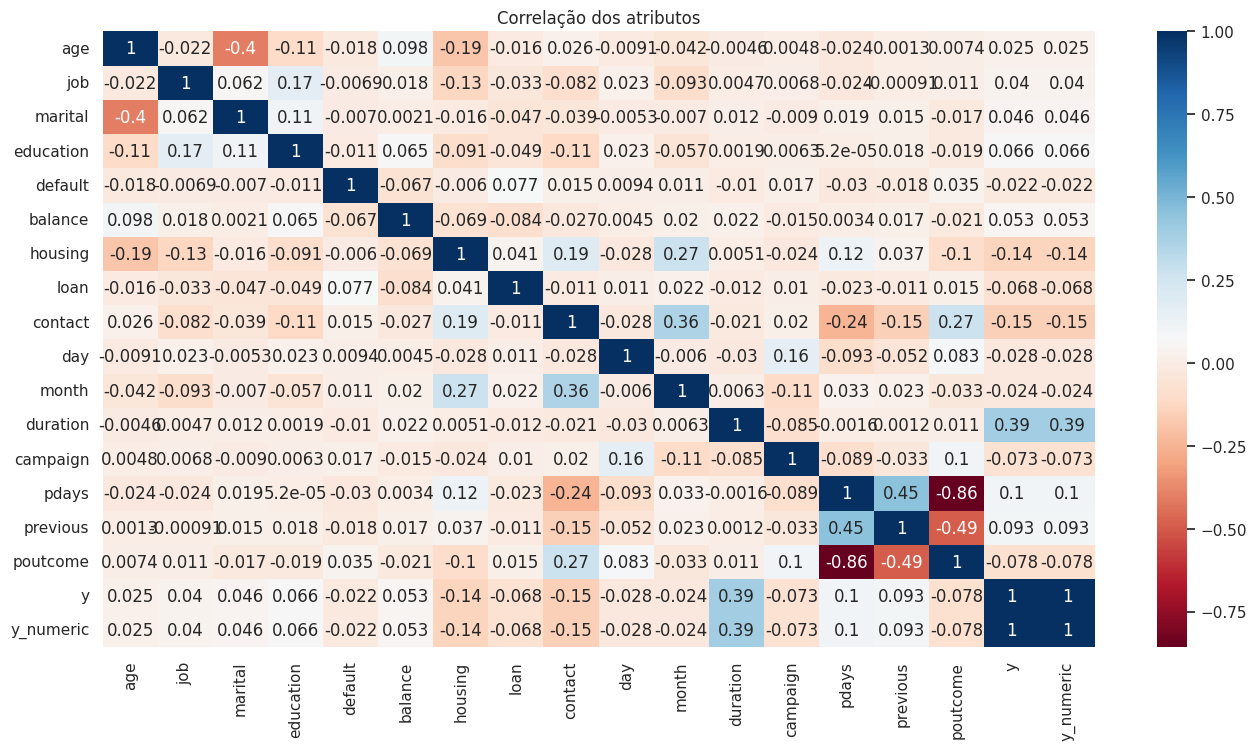

In [81]:
# fazendo uma cópia do dataset
df_selected = dataset.copy()

# Convertendo 'y' para valores numéricos para correlação
df_selected['y'] = df_selected['y'].map({'no': 0, 'yes': 1})

# Convertendo variáveis categóricas para tipo 'category' para análises
for cat in col_cat:
    df_selected[cat] = df_selected[cat].astype('category').cat.codes

# Calculando a correlação
correlation = df_selected.corr()

# Criando um heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(correlation, annot=True, cmap='RdBu')
plt.title("Correlação dos atributos")
plt.show()

O gráfico de dispersão (scatter plot) mostra as relações entre as variáveis numéricas. Ele permite visualizar tanto as distribuições individuais de cada variável quanto as relações entre elas. No caso do gráfico abaixo, foi incluída a classificação 0 para "no" e 1 para "yes", conforme a variável target "y".

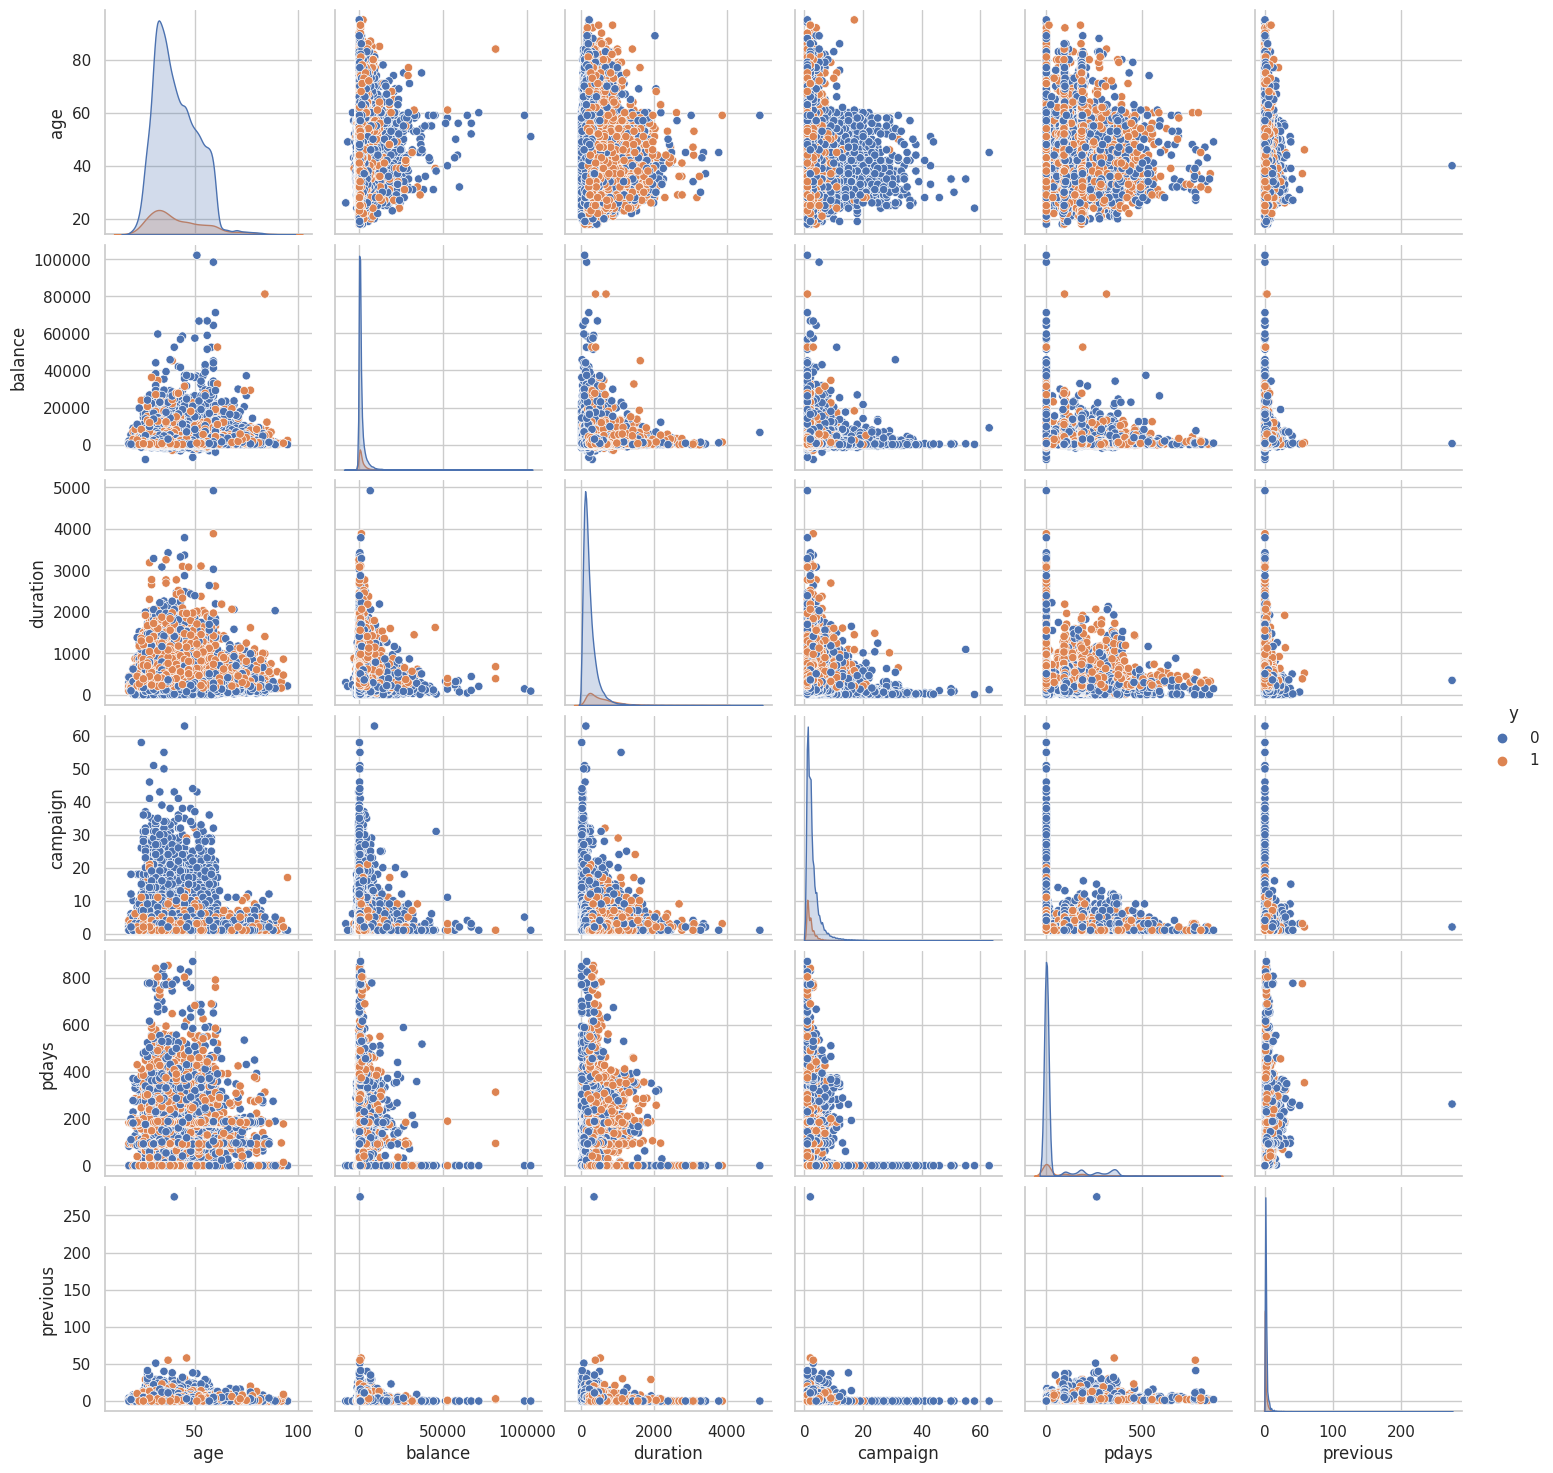

In [82]:
# separando os atributos numéricos com o target 'y'
df_selected = dataset[[*col_num, *col_y]].copy()

# convertendo a variável alvo para numérica
df_selected['y'] = df_selected['y'].map({'no': 0, 'yes': 1})

# Criando um pairplot para variáveis numéricas OBS.: Ele demora um pouco, mas fica pronto
sns.pairplot(df_selected, hue="y", height=2.5)

Embora a matriz de correlação tenha fornecido uma visão útil da relação entre variáveis numéricas e a variável alvo, outras técnicas podem ser mais adequadas quando se trata de dados categóricos e a interação entre variáveis. O teste de Chi-Square, por exemplo, é um método poderoso para determinar se há uma associação significativa entre duas variáveis categóricas. Este teste poderia fornecer insights sobre a relevância de variáveis categóricas no conjunto de dados para a previsão do resultado.

Além disso, a Análise de Variância (ANOVA) pode ser empregada para investigar se há diferenças significativas nas médias de uma variável numérica entre os grupos definidos por uma variável categórica. Em outras palavras, ANOVA pode ajudar a entender se a variável categórica tem um efeito significativo na variável numérica.

Portanto, para uma compreensão mais completa e um modelo de previsão mais robusto, seria apropriado considerar essas técnicas além da análise de correlação, especialmente ao lidar com dados categóricos.

##6. Pré-Processamento de dados

###6.1. Tratamento de Missings e Limpeza

No processo de pré-processamento dos dados, além da remoção cuidadosa de outliers, constatou-se que o conjunto de dados não apresenta valores faltantes. Para aprimorar a qualidade e a relevância dos dados para o modelo de aprendizado de máquina, optou-se por excluir registros contendo valores como 'unknown' e remover variáveis consideradas irrelevantes para o modelo. Isso inclui a exclusão das variáveis 'duration', 'day' e 'month', conforme anotado nas seções 5.3.9 e 5.3.10 da análise. Além disso, aplicaram-se filtros específicos para remover outliers em variáveis-chave:

Balance: Limitado a um intervalo de -2000 a 4000 para remover valores extremos que poderiam distorcer a análise.
Previous: Restrito a valores até 20, excluindo casos com um número excessivamente alto de contatos anteriores.
Pdays: Limitado a 600 dias, eliminando registros com longos períodos desde o último contato.
Campaign: Restringido a no máximo 30 contatos em uma campanha para excluir casos de campanhas excessivamente intensas.
Education e Job: Removidos registros com categorias 'unknown' para focar em dados com informações completas.
Age: Limitada a 70 anos para excluir idades atípicas no contexto dos dados.
Essas ações, combinadas com a ausência de valores faltantes, visam garantir que o modelo seja treinado com dados mais representativos e consistentes, melhorando potencialmente sua precisão e robustez.



In [83]:
# removendo duration de col_num conforme anotação em 5.3.10
col_num.remove('duration')

# removendo day e month de col_cat conforme anotação em 5.3.9
for col in ['day', 'month']:
    col_cat.remove(col)

# removendo duration, day e month do dataset, pois não terão utilidade no modelo de ML, conforme 5.3.9 e 5.3.10
dataset_sem_duration = dataset.drop(columns=['duration', 'day', 'month'], axis=1)

# removendo os outliers
df_limpo = dataset_sem_duration[
    (dataset['balance'] >= -2000) & (dataset['balance'] <= 4000) &
    (dataset['previous'] <= 20) & (dataset['pdays'] <= 600) &
    (dataset['campaign'] <= 30) & (dataset['education'] != 'unknown') &
    (dataset['job'] != 'unknown') & (dataset['age'] <= 70)
]

O gráfico de calor comparativo exibe as matrizes de correlação das variáveis numéricas com a variável alvo 'y', antes e após o processo de limpeza do dataset. Antes da limpeza, as correlações variavam de levemente positivas a negativas, com 'pdays' e 'previous' mostrando as correlações mais fortes com 'y'. Após a limpeza, que envolveu a remoção de outliers e registros com valores 'unknown', observa-se uma alteração nas correlações: 'balance' e 'previous' apresentam um aumento na correlação positiva com 'y', enquanto 'age' passa a ter uma correlação negativa leve. Estas mudanças indicam que o processo de limpeza impactou significativamente as relações entre as variáveis numéricas e a variável alvo, potencialmente melhorando a qualidade dos dados para análises e modelagem preditiva. Este gráfico fornece uma visão clara de como a limpeza dos dados afeta as relações internas do conjunto de dados, ressaltando a importância de um pré-processamento cuidadoso na preparação de dados para análises mais precisas e confiáveis.

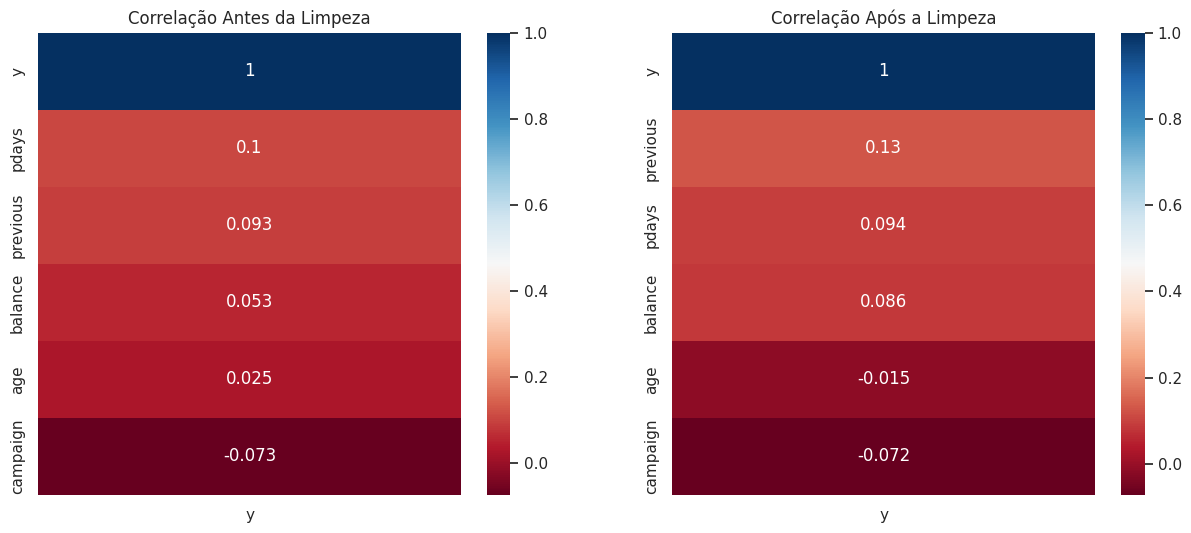

In [84]:
# separando os atributos numéricos com o target 'y'
df_temp = dataset[[*col_num, *col_y]].copy()

# separando os atributos numéricos com o target 'y' para o dataset limpo
df_temp_limpo = df_limpo[[*col_num, *col_y]].copy()

# convertendo a variável alvo para numérica
df_temp['y'] = df_temp['y'].map({'no': 0, 'yes': 1})
df_temp_limpo['y'] = df_temp_limpo['y'].map({'no': 0, 'yes': 1})

# Criando a figura com subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# visualizando a matriz de correlação
sns.heatmap(df_temp.corr()[['y']].sort_values(by='y', ascending=False), annot=True, cmap='RdBu', ax=axes[0])
axes[0].set_title('Correlação Antes da Limpeza')

# visualizar a matriz de correlação
sns.heatmap(df_temp_limpo.corr()[['y']].sort_values(by='y', ascending=False), annot=True, cmap='RdBu', ax=axes[1])
axes[1].set_title('Correlação Após a Limpeza')

plt.show()

###6.2. Feature selection

Na fase de seleção de características, optei por técnicas específicas para lidar com atributos numéricos e categóricos. Para as variáveis contínuas, a Análise de Variância (ANOVA) foi minha escolha, já que é eficaz para identificar diferenças significativas entre as médias de grupos, fornecendo uma base sólida para a seleção de características numéricas. Por outro lado, empreguei o teste de Chi-Square para as variáveis categóricas, avaliando a independência entre essas variáveis e nosso alvo, permitindo a identificação de recursos que possuem uma correlação maior com nossa variável de saída.

Para minimizar o ruído e o potencial de overfitting, apliquei uma estratégia que mantém apenas as características mais importantes - selecionando os 67% superiores dos atributos disponíveis. Isso proporciona um equilíbrio, garantindo que nosso modelo seja alimentado com informações de qualidade, ao mesmo tempo que evita ajustar excessivamente aos dados de treinamento, o que poderia comprometer a capacidade do modelo de generalizar para dados não vistos.

Para chegar a essa proporção, escolhi 4 atributos numéricos e 6 categóricos, representando um total de 10. Esta distribuição foi baseada na observação de que nosso conjunto de dados possui mais atributos categóricos relevantes (conforme indicado pelas pontuações do teste de Chi-Square) em comparação aos atributos numéricos, oferecendo assim um mix equilibrado de ambos os tipos de características para nosso modelo.

Separando os dados entre numéricos e categóricos.

In [85]:
# cópia dos atributos sem a coluna target
X = df_limpo.drop(columns=['y'], axis=1)

# atributos numéricos
X_num = X[col_num].copy()

# atributos categóricos
X_cat = X[col_cat].copy()

# target
y = df_limpo[col_y].copy()

# quantidade de atributos numéricos escolhidos
n_attr_num = 4

# quantidade de atributos categóricos escolhidos
n_attr_cat = 6

a) Aplicando ANOVA sobre atributos numéricos


In [86]:
feat_num = select_best_features(X_num, y, n_attr_num, f_classif)


Número original de atributos: 5
Número reduzido de atributos: 4

Atributos melhores pontuados:
 1) previous    : 637.7969
 2) pdays       : 349.9664
 3) balance     : 292.9075
 4) campaign    : 204.1671


b) Aplicando Chi-Square sobre os atributos categóricos

In [87]:
# codificando os atributos categóricos
label_encoder = LabelEncoder()
X_cat_enc = X_cat.apply(label_encoder.fit_transform)

feat_cat = select_best_features(X_cat_enc, y, n_attr_cat, chi2)


Número original de atributos: 8
Número reduzido de atributos: 6

Atributos melhores pontuados:
 1) contact     : 1013.2786
 2) housing     : 274.0988
 3) job         : 136.4212
 4) loan        : 133.0916
 5) education   : 93.7432
 6) poutcome    : 76.2958


c) Lista com os atributos escolhidos

In [88]:
# lista de atributos categóricos escolhidos
col_cat_esc = list(feat_cat.keys())

# lista de atributos numéricos escolhidos
col_num_esc = list(feat_num.keys())

# atributos escolhidos
attr_escolhidos = [*col_num_esc, *col_cat_esc]
attr_escolhidos

['previous',
 'pdays',
 'balance',
 'campaign',
 'contact',
 'housing',
 'job',
 'loan',
 'education',
 'poutcome']

###6.3. Separação em conjunto de treino e teste com holdout

In [89]:
test_size = 0.30 # tamanho do conjunto de teste
seed = 42 # semente aleatória

# definição de X com os atributos escolhidos em 6.2. e y
X = df_limpo[attr_escolhidos].copy()
y = df_limpo['y'].copy()

# holdout com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y
)

# parâmetros e partiçoes da validação cruzada
scoring = 'roc_auc'
num_particoes = 10

# validação cruzada com estratificação
kfold = StratifiedKFold(
    n_splits=num_particoes, shuffle=True, random_state=seed,
)

A AUC-ROC é uma métrica de desempenho para problemas de classificação binária. Ela informa quão bom o modelo criou as classificações, variando o limiar de discriminação. ROC é uma curva de probabilidade e AUC representa o grau ou medida de separabilidade. Quanto maior a AUC, melhor o modelo está em prever 0s como 0s e 1s como 1s. Por exemplo, uma AUC de 1,0 significa que o modelo tem 100% de capacidade de distinguir as diferentes classes. Em outras palavras, é capaz de fazer uma separação perfeita entre a classe positiva e a classe negativa.

Vale destacar que a AUC-ROC é uma medida robusta à desbalanceamento de classes e funciona bem mesmo se houver um alto desequilíbrio entre a classe positiva e a classe negativa, que é o caso do problema estudado.

###6.4. Transformações dos dados

No processo de preparação de dados para o treinamento de modelos de aprendizado de máquina, decidi adotar duas técnicas de escalonamento diferentes para os atributos numéricos, com base em suas características de distribuição, e uma técnica de codificação para os atributos categóricos.

Primeiramente, construí um pipeline chamado 'num_norm_pipeline' que aplica a técnica de MinMaxScaler aos atributos numéricos. Essa técnica de escalonamento transforma os dados de modo que eles fiquem dentro de um intervalo específico, geralmente entre 0 e 1, mantendo sua distribuição original. Optei por usar MinMaxScaler para atributos numéricos que não apresentavam uma distribuição próxima à normal.

Em seguida, estabeleci outro pipeline, 'num_padr_pipeline', para processar atributos numéricos que seguem uma distribuição próxima à normal. Este pipeline aplica a técnica de StandardScaler, que padroniza os dados para terem uma média igual a 0 e um desvio padrão igual a 1. Esta técnica é adequada para dados com uma distribuição próxima à normal.

Para atributos categóricos, criei um terceiro pipeline, 'cat_pipeline', que aplica o OneHotEncoder. Este codificador transforma cada categoria única em um novo atributo binário, o que facilita o processo de aprendizado para muitos modelos de aprendizado de máquina.

Todos esses pipelines são então combinados em um único pipeline, chamado 'full_pipeline', usando a classe ColumnTransformer. Cada pipeline é aplicado a um conjunto específico de colunas, definido pelas listas 'col_num_norm', 'col_num_padr' e 'col_cat_esc'.

Por fim, com a variável alvo 'y_train', utilizo a técnica de codificação de labels, LabelEncoder, que transforma as categorias em números inteiros. Isso é feito para permitir que os modelos de aprendizado de máquina processem a variável alvo, uma vez que esses modelos geralmente requerem que a entrada seja numérica. Portanto, com a variável alvo 'y_train' transformada em 'y_train_transf', estou pronto para treinar o modelo.

- Define os atributos numéricos que vão ser transformados utilizando MinMaxScaler e StandardScaler

In [90]:
# atributos para normalizar
col_num_norm = ['pdays', 'previous']

# atributos para padronizar
col_num_padr = [col for col in col_num_esc if col not in col_num_norm]

print(f"{'Normalizar:':14} {'Padronizar:':18}")
for col1, col2 in zip(col_num_norm, col_num_padr):
    print(f'{col1:14} {col2:18}')

Normalizar:    Padronizar:       
pdays          balance           
previous       campaign          


In [91]:
# Cria um pipeline para pré-processar as variáveis numéricas com MinMaxScaler
num_norm_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())  # Aplica o MinMaxScaler para normalização
])


# Cria um pipeline para pré-processar as variáveis numéricas com StandardScaler
num_padr_pipeline = Pipeline([
    ('std_scaler', StandardScaler())  # Aplica o StandardScaler para padronização
])

# Cria um pipeline para pré-processar as variáveis categóricas
cat_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(sparse=False))  # Aplica o OneHotEncoder para codificar as variáveis categóricas
])

# Combina os pipelines para variáveis numéricas e categóricas em um único pipeline
full_pipeline = ColumnTransformer([
    ('num_norm', num_norm_pipeline, col_num_norm),
    ('num_padr', num_padr_pipeline, col_num_padr),
    ('cat', cat_pipeline, col_cat_esc)
])

# Inicializa um LabelEncoder
label_encoder = LabelEncoder()

# Usa o LabelEncoder para transformar a variável alvo y_train
y_train_transf = label_encoder.fit_transform(y_train)  # Codifica a variável alvo como uma variável numérica


##7. Conclusão

Neste MVP, foi possível verificar a importância de um processo de análise de dados detalhado e bem fundamentado, destacando-se a relevância da definição clara do problema e da aplicação de boas práticas em todas as etapas. Através da carga cuidadosa do dataset, da utilização de funções Python úteis e da realização de análises estatísticas descritivas e gráficos unimodais e multimodais, obtivemos insights valiosos sobre o comportamento e as características dos dados. O pré-processamento de dados, incluindo a remoção de outliers e a limpeza de variáveis irrelevantes ou incompletas, foi crucial para garantir a qualidade e a integridade dos dados, o que é essencial para a construção de modelos de aprendizado de máquina eficientes. Este MVP ressalta a importância de uma abordagem metódica e criteriosa na análise de dados, que é fundamental para extrair conhecimentos significativos e orientar decisões informadas.

